### Goal

In this case study, we will focus only on rating, review attributes to develop a Sentiment Analyzer model to categorize review either positive or negative.

1. Mapping of rating with 1 to 10 binary classes(positive or negative).
2. Try to solve real-time challenges related to Sentiment Analyzer: Sarcasm, Multipolarity, and Negation.
3. Deploy NLP and ML models to categorize English text reviews as Positive or Negative.
4. Deploy the Sentiment Analyzer model on the local server using Flask.

In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [143]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

In [144]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk import wordnet
from nltk.corpus import stopwords

In [145]:
from wordcloud import WordCloud, STOPWORDS
import re
import string
import unicodedata
from string import punctuation
import warnings
warnings.filterwarnings('ignore')

<b>Loading of Data</b>

In [146]:
%%time
df = pd.read_csv('IMDB-Dataset.csv', encoding='latin-1')

CPU times: total: 7.7 s
Wall time: 9.5 s


In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Ratings   150000 non-null  float64
 1   Reviews   150000 non-null  object 
 2   Movies    149975 non-null  object 
 3   Resenhas  150000 non-null  object 
dtypes: float64(1), object(3)
memory usage: 4.6+ MB


In [148]:
#Converting object datatype to string
df['Reviews'] = df['Reviews'].astype("string")
df['Movies'] = df['Movies'].astype("string")

In [149]:
#Dropping column which is useless for us
df.drop(['Resenhas'], axis=1, inplace= True)

In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Ratings  150000 non-null  float64
 1   Reviews  150000 non-null  string 
 2   Movies   149975 non-null  string 
dtypes: float64(1), string(2)
memory usage: 3.4 MB


#### Data Cleaning and Preprocessing

In [151]:
#Customizing the stopword as per our requirement
stop_words = stopwords.words('english')
new_stopwords = ['movie', 'one', 'film', 'would', 'shall', 'could', 'might']
stop_words.extend(new_stopwords)
# To deal with negation type comments we are removing not from our stopwords
stop_words.remove('not')
stop_words = set(stop_words)

In [152]:
# Removing special characters
def rmv_spcl_char(content):
    return re.sub('\[[^&@#!]]*\]', '', content)

In [153]:
#Removing URLs
def rmv_url(content):
    return re.sub(r'http\S+', '', content)

In [154]:
#Removing the stopwords from text
def rmv_stpwrds(content):
    clean_data = []
    for i in content.split():
        if i.lower() not in stop_words and i.isalpha():
            clean_data.append(i.strip().lower())
    return " ".join(clean_data)

In [155]:
# Expansion of english contactions
def cntrct_expnsn(content):
    content = re.sub(r"won\'t", "would not", content)
    content = re.sub(r"can\'t", "can not", content)
    content = re.sub(r"don\'t", "do not", content)
    content = re.sub(r"shouldn\'t", "should not", content)
    content = re.sub(r"needn\'t", "need not", content)
    content = re.sub(r"hasn\'t", "has not", content)
    content = re.sub(r"haven\'t", "have not", content)
    content = re.sub(r"weren\'t", "were not", content)
    content = re.sub(r"wasn\'t", "was not", content)
    content = re.sub(r"mightn\'t", "might not", content)
    content = re.sub(r"didn\'t", "did not", content)
    content = re.sub(r"n\'t", " not", content)
    content = re.sub(r"\'re", " are", content)
    content = re.sub(r"\'s", " is", content)
    content = re.sub(r"\'d", " would", content)
    content = re.sub(r"\'ll", " will", content)
    content = re.sub(r"\'ve", "have", content)
    content = re.sub(r"\'m", " am", content)
    return content

In [156]:
#We should call remove stopwords after calling contaction expansion function else stopwords will be there in our data. 
def data_cleaning(content):
    content = rmv_spcl_char(content)
    content = rmv_url(content)
    content = cntrct_expnsn(content)
    content = rmv_stpwrds(content)
    return content

In [157]:
%%time
#Cleaning of data
df['Reviews'] = df['Reviews'].apply(data_cleaning)

CPU times: total: 30.6 s
Wall time: 41.7 s


In [158]:
df['Reviews'].head()

0                                                                                                                                                                 watched conditional see films not caught dead giving hard earned money explain depth write shortest not see far unbelievably unfunny ever total since hatred others like extends far beyond think go not know people besides carmen vanessa kim not though think editing flat possibly blatant continuity errors make crapfast even crappier thought know films not supposed serious come someone gets minor facial next someone gets cut blood least cut since narnia films away give disaster pass thoughtless mindless physical gags obviously take popular movies last year late including best picture know saddest thing stupid movies not care much money many cameos sorry ass excuses films taking away jobs directors truly deserve thought better taste ashamed making kind jason friedberg aaron burn guys contributing decline western cause downfall wes

#### Data Overview

In [159]:
#Checking of missing values
df.isna().sum()

Ratings     0
Reviews     0
Movies     25
dtype: int64

In [160]:
#As we are not much interested in Movies attributes so we can digest the missing values in this attributes

In [161]:
df['Ratings'].describe()

count    150000.000000
mean          5.500000
std           2.872291
min           1.000000
25%           3.000000
50%           5.500000
75%           8.000000
max          10.000000
Name: Ratings, dtype: float64

In [162]:
df['Reviews'].describe()

count     150000
unique    149745
top             
freq          10
Name: Reviews, dtype: object

In [163]:
df['Movies'].describe()

count         149975
unique         14206
top       Apparition
freq              25
Name: Movies, dtype: object

In [164]:
# Top : the most frequent value
# freq : frequency of the most frequent value

#### Exploratory Data Analysis

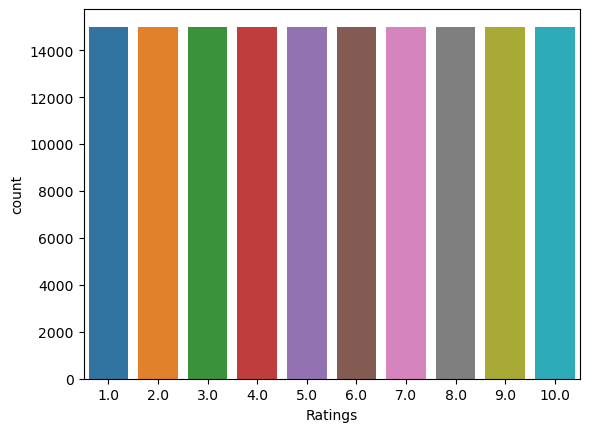

Ratings
1.0     15000
2.0     15000
4.0     15000
3.0     15000
5.0     15000
6.0     15000
8.0     15000
7.0     15000
10.0    15000
9.0     15000
Name: count, dtype: int64


In [165]:
#Checking for class imbalance
sns.countplot(x=df['Ratings'])
plt.show()
print(df['Ratings'].value_counts())

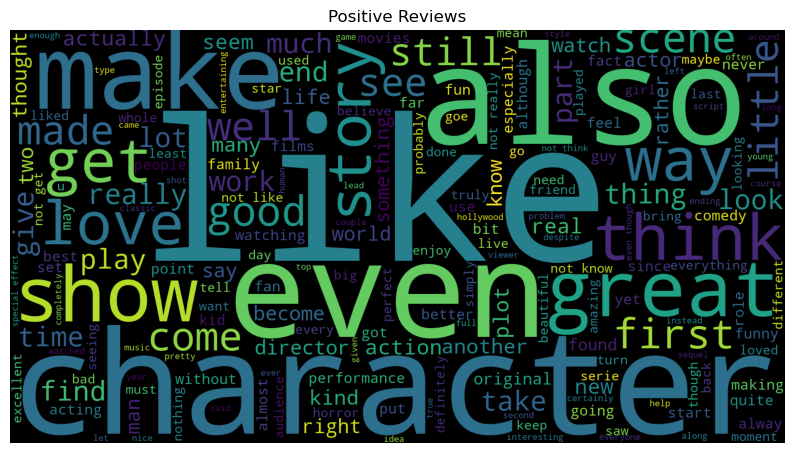

CPU times: total: 1min 13s
Wall time: 1min 37s


In [166]:
%%time
#Visualization of Important words from positive Reviews
sentences = df['Reviews']
pos = ' '.join(map(str,sentences[df['Ratings']>=7]))

pos_wordcloud = WordCloud(width = 1500,
                          height = 800,
                         background_color = 'black',
                         stopwords = stop_words,
                         min_font_size = 15).generate(pos)

plt.figure(figsize=(10,10))
plt.imshow(pos_wordcloud)
plt.title('Positive Reviews')
plt.axis('off')
plt.show()

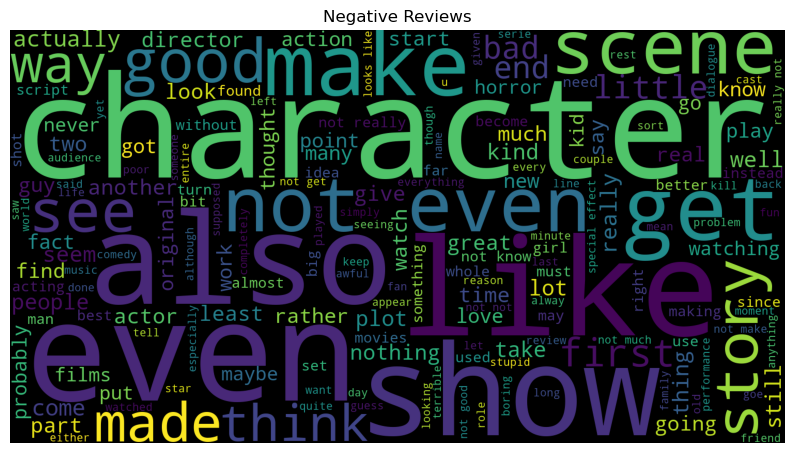

In [167]:
#Visualization of Important words from negative Reviews
neg = ' '.join(map(str,sentences[df['Ratings']<=4]))

neg_wordcloud = WordCloud(width = 1500,
                          height = 800,
                         background_color = 'black',
                         stopwords = stop_words,
                         min_font_size = 15).generate(neg)

plt.figure(figsize=(10,10))
plt.imshow(neg_wordcloud)
plt.title('Negative Reviews')
plt.axis('off')
plt.show()

<b>Basics Statistics of Review Data</b>

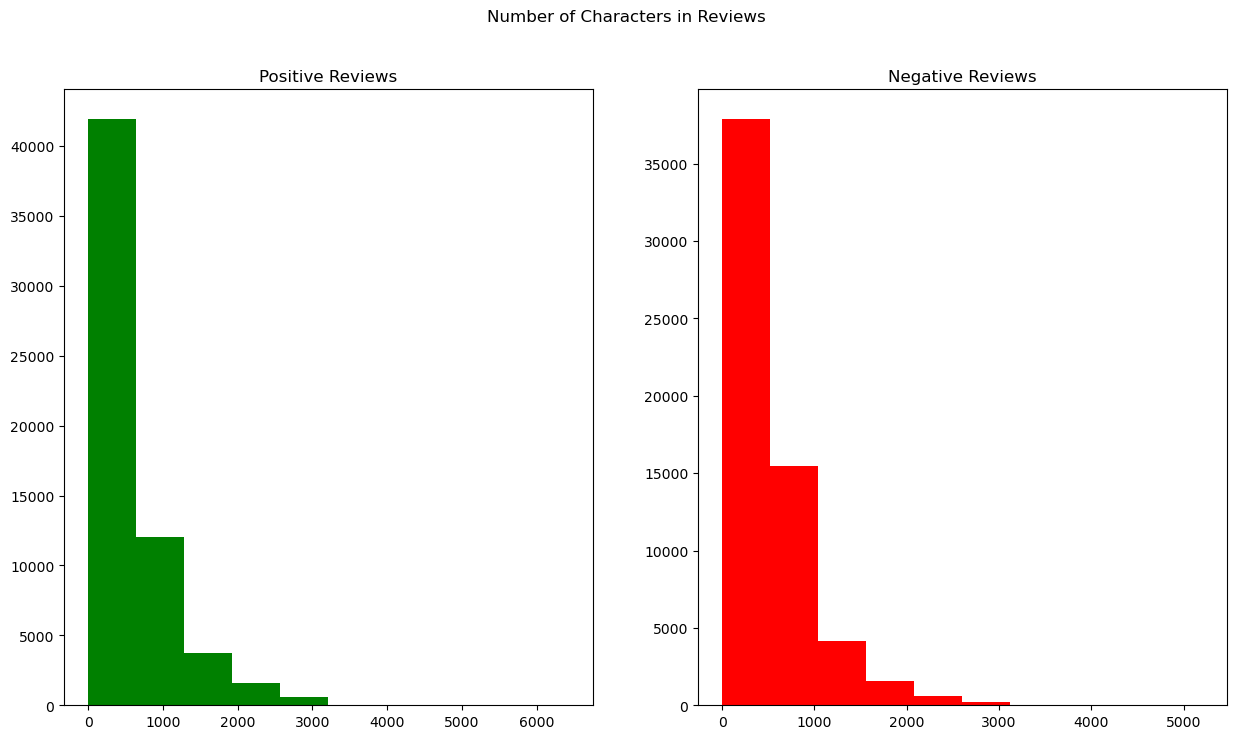

In [168]:
#Visualization of number of character in reviews
figure, (pos_ax, neg_ax) = plt.subplots(1,2,figsize = (15,8))
len_pos_review = df[df['Ratings']>=7]['Reviews'].str.len()
pos_ax.hist(len_pos_review, color = 'green')
pos_ax.set_title('Positive Reviews')
len_neg_review = df[df['Ratings']<=4]['Reviews'].str.len()
neg_ax.hist(len_neg_review, color = 'red')
neg_ax.set_title("Negative Reviews")
figure.suptitle('Number of Characters in Reviews')
plt.show()

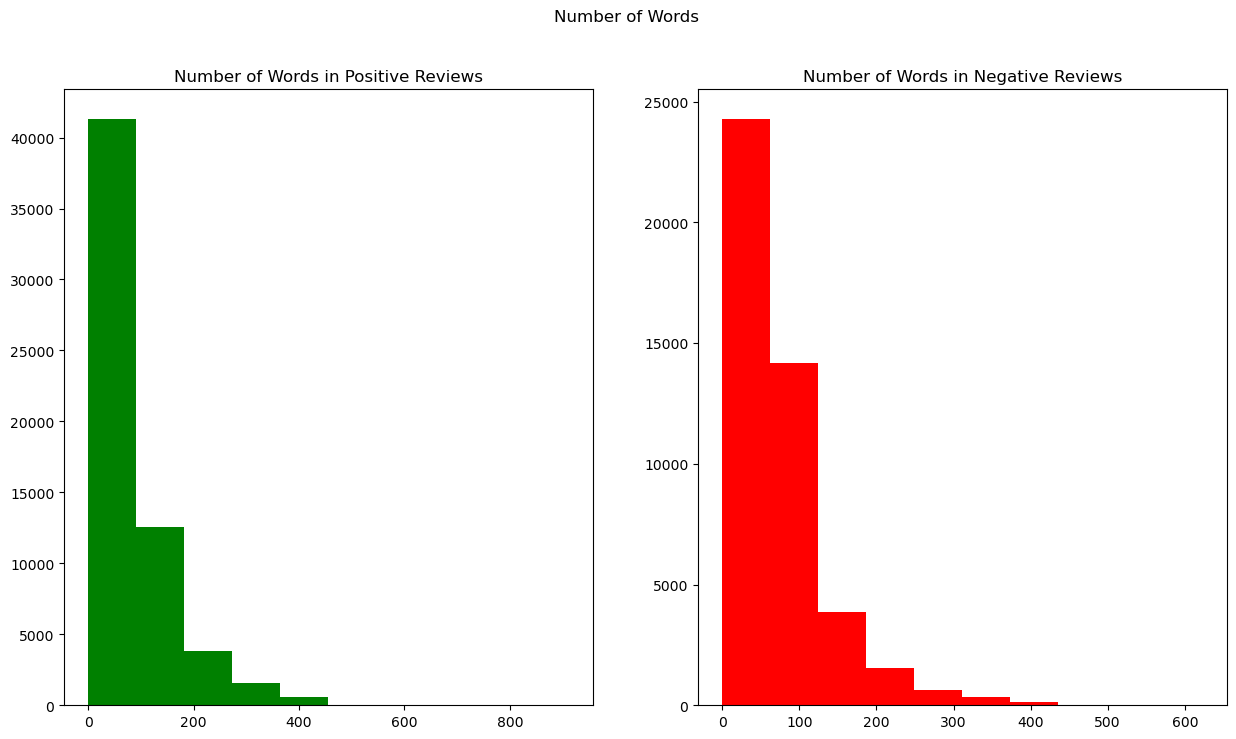

In [169]:
#Visualization of number of words in reviews
figure,(pos_ax, neg_ax) = plt.subplots(1,2,figsize=(15,8))
pos_word = df[df['Ratings']>=7]['Reviews'].str.split().map(lambda review: len(review))
pos_ax.hist(pos_word, color = 'green')
pos_ax.set_title('Number of Words in Positive Reviews')
neg_word = df[df['Ratings']<4]['Reviews'].str.split().map(lambda review: len(review))
neg_ax.hist(neg_word, color='red')
neg_ax.set_title('Number of Words in Negative Reviews')
figure.suptitle('Number of Words')
plt.show()

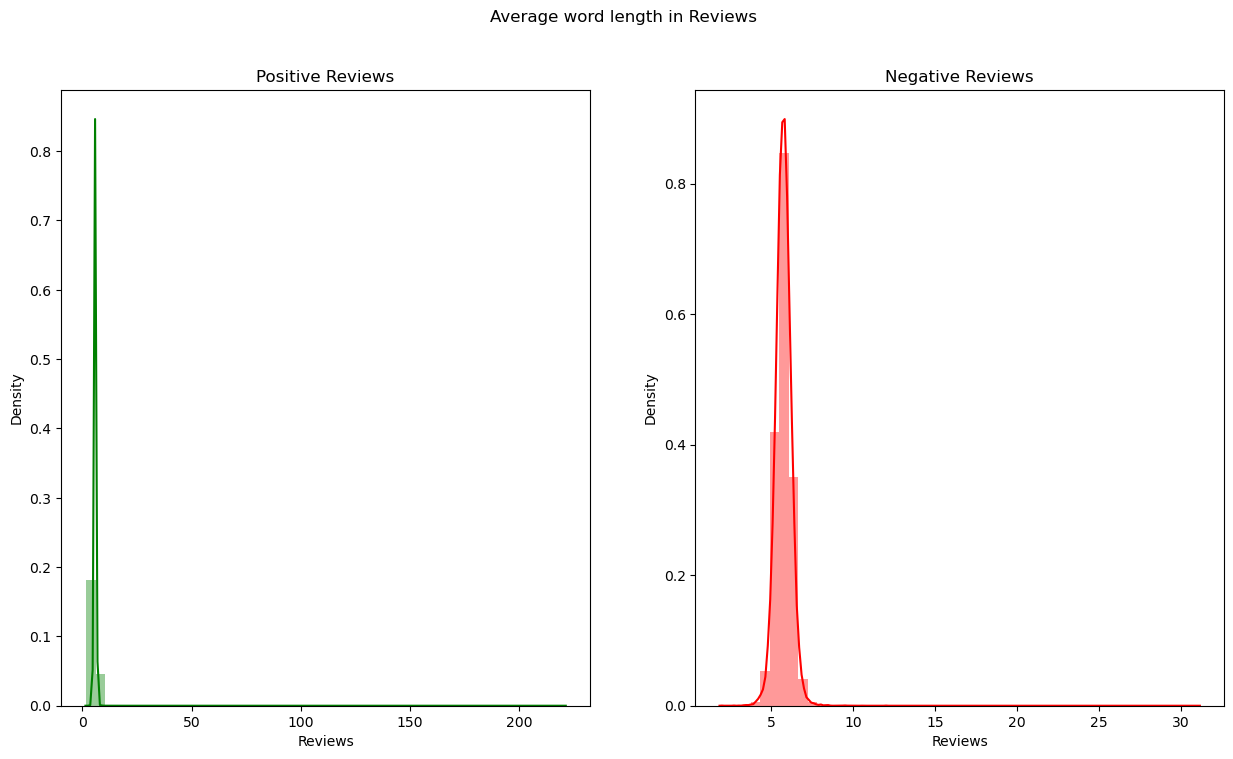

In [170]:
#Visualize average of words in reviews
figure,(pos_ax, neg_ax) = plt.subplots(1,2,figsize=(15,8))
pos_word = df[df['Ratings']>=7]['Reviews'].str.split().map(lambda x: [len(i) for i in x])
sns.distplot(pos_word.map(lambda x: np.mean(x)), ax=pos_ax, color = 'green')
pos_ax.set_title('Positive Reviews')

neg_word = df[df['Ratings']<=4]['Reviews'].str.split().map(lambda x: [len(i) for i in x])
sns.distplot(neg_word.map(lambda x: np.mean(x)), ax=neg_ax, color = 'red')
neg_ax.set_title('Negative Reviews')

figure.suptitle('Average word length in Reviews')
plt.show()

In [171]:
#Get important features by using Countvectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = {word:Count for word , Count in sorted(vec.vocabulary_.items(), key=lambda item:item[1], reverse=True)}
    words_freq_df = pd.DataFrame.from_dict(words_freq,orient='index')
    return words_freq_df[:n]

In [172]:
%%time
most_common_uni = get_top_text_ngrams(df.Reviews[df['Ratings']>=7],20,1)

CPU times: total: 22.5 s
Wall time: 26.6 s


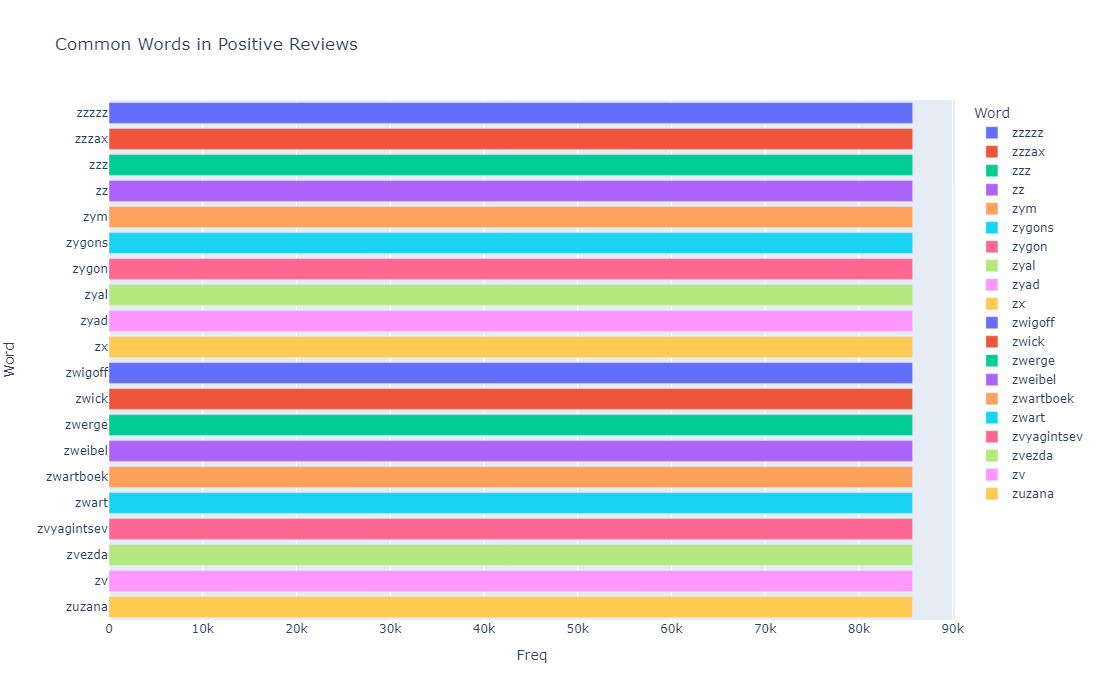

In [173]:
#a=pd.DataFrame(most_common_uni).reset_index()
a = most_common_uni.reset_index()
a.columns=["Word", "Freq"]
fig = px.bar(a, x="Freq", y='Word', 
             title='Common Words in Positive Reviews', 
             orientation = 'h',
             width = 700,
            height = 700,
            color = 'Word')
fig.show()

In [174]:
def preprocessing0(x):
    f=x.split()
    f_words=[word for word in f if (not word.startswith(("z", "x", "y"))) ]
    return " ".join(f_words)

In [175]:
%%time
df["Reviews"]=df["Reviews"].apply(preprocessing0)

CPU times: total: 7.5 s
Wall time: 8.69 s


In [176]:
%%time
#Finding the unigrams again
most_common_uni = get_top_text_ngrams(df.Reviews[df['Ratings']>=7],20,1)

CPU times: total: 23.3 s
Wall time: 27.3 s


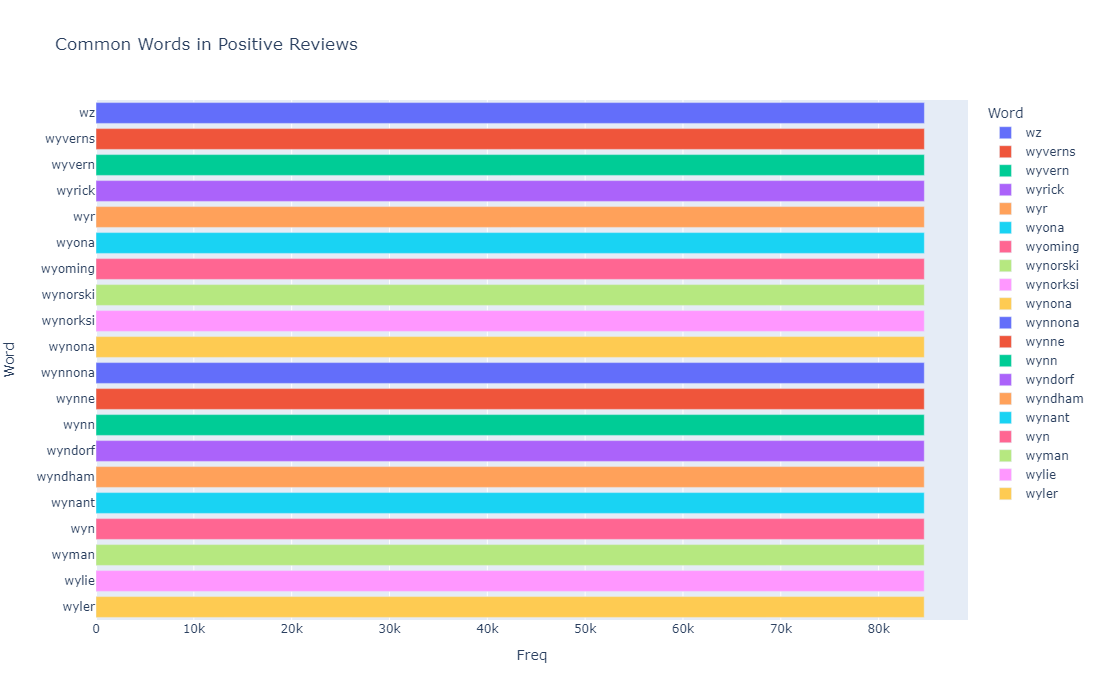

In [177]:
a = most_common_uni.reset_index()
a.columns=["Word", "Freq"]
fig = px.bar(a, x="Freq", y='Word', 
             title='Common Words in Positive Reviews', 
             orientation = 'h',
             width = 700,
            height = 700,
            color = 'Word')
fig.show()

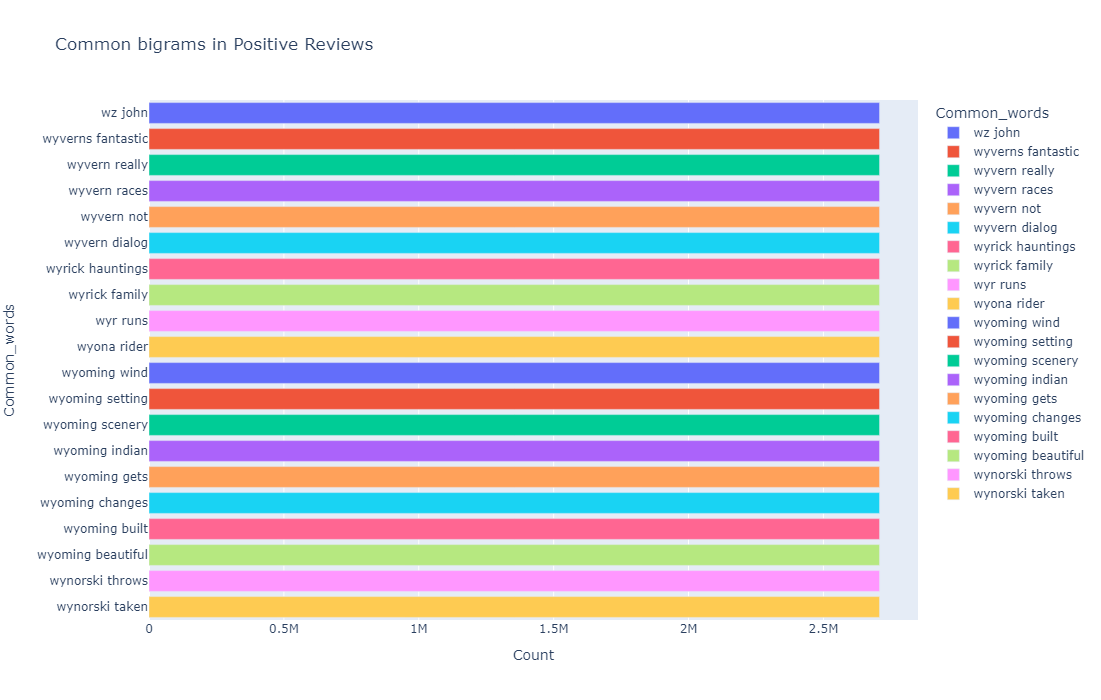

CPU times: total: 1min 5s
Wall time: 1min 19s


In [178]:
%%time
most_common_uni = get_top_text_ngrams(df.Reviews[df['Ratings']>=7],20,2)
temp=pd.DataFrame(most_common_uni).reset_index()
temp.columns=["Common_words", "Count"]
fig = px.bar(temp, x="Count", y='Common_words', 
             title='Common bigrams in Positive Reviews', 
             orientation = 'h',
             width = 700,
             height = 700,
             color = 'Common_words')
fig.show()

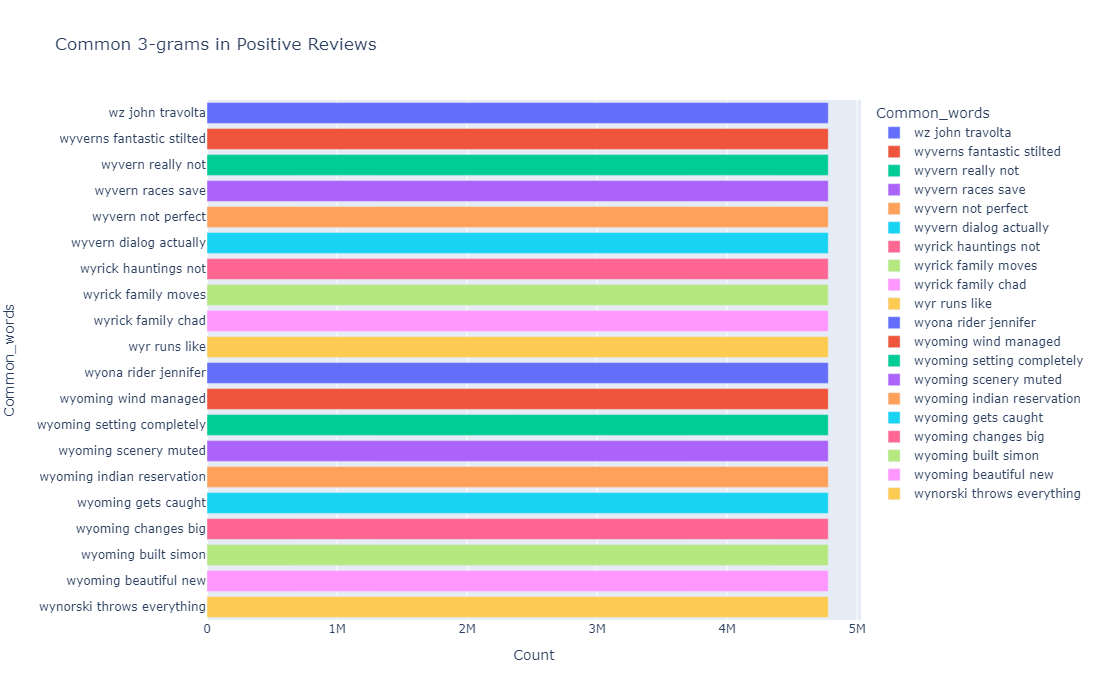

In [179]:
most_common_uni = get_top_text_ngrams(df.Reviews[df['Ratings']>=7],20,3)
temp=pd.DataFrame(most_common_uni).reset_index()
temp.columns=["Common_words", "Count"]
fig = px.bar(temp, x="Count", y='Common_words', 
             title='Common 3-grams in Positive Reviews', 
             orientation = 'h',
             width = 700,
             height = 700,
             color = 'Common_words')
fig.show()

In [180]:
pd.options.display.max_colwidth = 1000
df[['Reviews', 'Ratings', 'Movies']][(df['Ratings']>=7)&(df['Reviews'].str.contains('not perfect| not like| not want| not know| not get| not really '))].head()

Reviews  \
48406                                                                                                                                                                                                                                                                                                             steven seagal getting old also not shape ago certainly still make great pretty lot money spent making realistic reminds good old days van damme seagal backed big justice colorful filled explosive action great dialogues fight scenes seagal actually takes since really saw perform anything close aikido balance realism utter irrealism got remind action movies genre lots folks try bring various not get like romantic comedies politic thrillers follow basic action movies also lead set expect villains hero beautiful guns production direction sometimes reminded hand held little part scenes sometime get feeling still direct video guess include cheesy downside picture pretty hard follow keep characters   
90003  first seen lot films time nowhere near bottom anything sheer volume votes people not bothered see means review probably get lost think deserves better getting try not go plot seen except say usual love story sort not think filmmakers going anything mindblowingly original end get sweet lighthearted takes everyday setting throws fairly although characters builds simple little interwoven romance around outset not difficult predict happen acting paris hilton not call good means teeth grindingly bad characters june taken extreme terms looks talent respectively bad aforementioned things prevent getting fully immersed things constantly reminded watching think thats okay something wants entertain actors shot script however well matched cinematography general feel made laugh several times say recent interactions characters handled well ancillary characters neither infringed upon main ones felt pointlessly lost whilst not world better ihave seen lot films shots felt place jarred flow found e...   
90011                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                nation strange directed real life horror filmmaker ulli corrupt cop disturbing childhood made twisted sociopath not get shadier messes wrong person whole career comes crashing fate lies ahead officer watch odd entertaining nation shot ulli lommel cameo well david expecting dollar not watch want watch not take seriously enjoy bit different herr lommel serial killer based amused not look much   
90015                                                                                                                                                                                                                                                                                                                                                                                                                                 honest not watch initially bad reviews professional got dvd thought not watch least really enjoyed fist minutes decided watch entire honest not bad reviews not know reviewers not like anyhow lets talk story fine screenplay dialogues situations laughed almost every saif role mental guy stole show ram kapoor roles felt ritesh not get excellent lines deliver got movies like masti girls small roles nothing much wonder made serious actor like bipasha type anyhow feel sajid khan good people watch reviewers not taste like humshakals bette

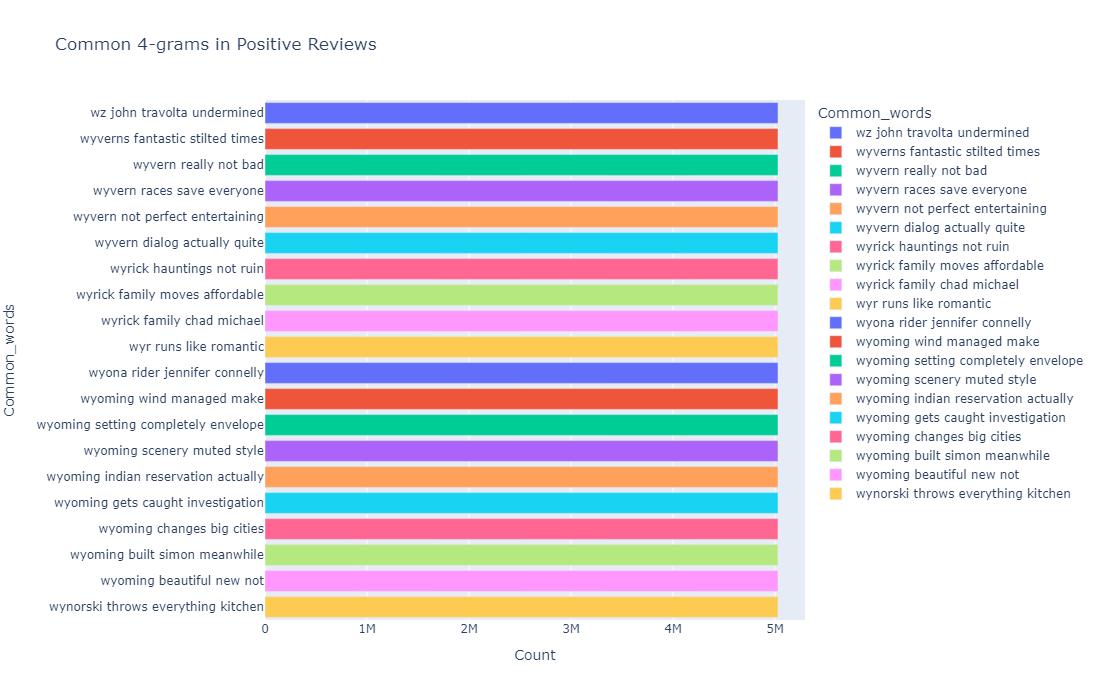

In [181]:
most_common_uni = get_top_text_ngrams(df.Reviews[df['Ratings']>=7],20,4)
temp=pd.DataFrame(most_common_uni).reset_index()
temp.columns=["Common_words", "Count"]
fig = px.bar(temp, x="Count", y='Common_words', 
             title='Common 4-grams in Positive Reviews', 
             orientation = 'h',
             width = 700,
             height = 700,
             color = 'Common_words')
fig.show()

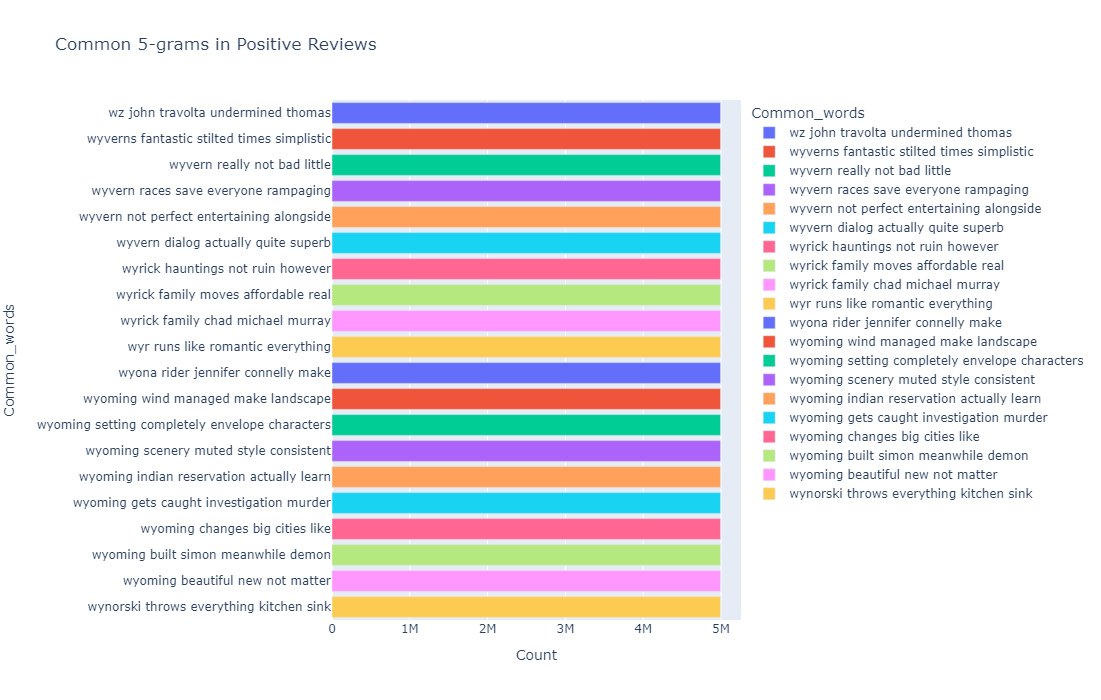

CPU times: total: 1min 29s
Wall time: 1min 41s


In [182]:
%%time
most_common_uni = get_top_text_ngrams(df.Reviews[df['Ratings']>=7],20,5)
temp=pd.DataFrame(most_common_uni).reset_index()
temp.columns=["Common_words", "Count"]
fig = px.bar(temp, x="Count", y='Common_words', 
             title='Common 5-grams in Positive Reviews', 
             orientation = 'h',
             width = 700,
             height = 700,
             color = 'Common_words')
fig.show()

In [183]:
pd.options.display.max_colwidth = 1000
df[['Reviews', 'Ratings', 'Movies']][(df['Ratings']>=7)&(df['Reviews'].str.contains('blah blah blah| la la la la| mario mario mario mario'))].head()

Reviews  \
98873                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              english girl roald dahl hero mine growing wes anderson favourite directors combination american traditional english children fiction little contrived highlight psychotic break finale fantastic mr fox driving motorbike sidecar abruptly stops next mountainous backdrop sees outline despite unsuccessful attempts communication scene wonderful example deranged blah blah blah blah blah blah blah blah   
108807                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 see lot people seriously trying trash word advice stop action flick not oscar worthy contender people die slowly grips heart blah blah blah get goes along pretty fast pace manages give bit homage original entries adding bit fun creativity theater packed part goers enjoyed advice go see fun learn not take every frickin real fan   
109752                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 worth good sunday afternoon blah blah stop reading go watch blah blah blah stop reading go watch blah blah blah stop reading go watch blah blah blah stop reading go watch blah blah blah stop reading go watch blah blah blah stop reading go watch blah blah blah stop reading go watch blah blah blah stop reading go watch blah blah blah stop reading go watch blah blah blah stop reading go watch   
112899  end beginning pumpkin spice football transitional season approach another animated drops fangs sinks waiting juvenile vivid description serve opening latest review assignment hotel transylvania halloween still weeks adam sandler buddies release animated sequel hopes kicking october franchise keep fun join list unimpressive read find first hotel transylvania cute family qualities number two amplifies next level dracula dennis big pitched toddler whose innocence leads teach old monster kid journey filled half baked overused running gags funny eventually get stale point blah blah blah sandler team uses usual bag tricks spur many ploys entertaining wave kids sandler wit seems come little writers poke fun number modern day relevant cell social even modern day television icons cakey mocked lord darkness ridiculous things humor cuteness much like tale much feeling despite events first dracula still issues whole racial thing team must run lot

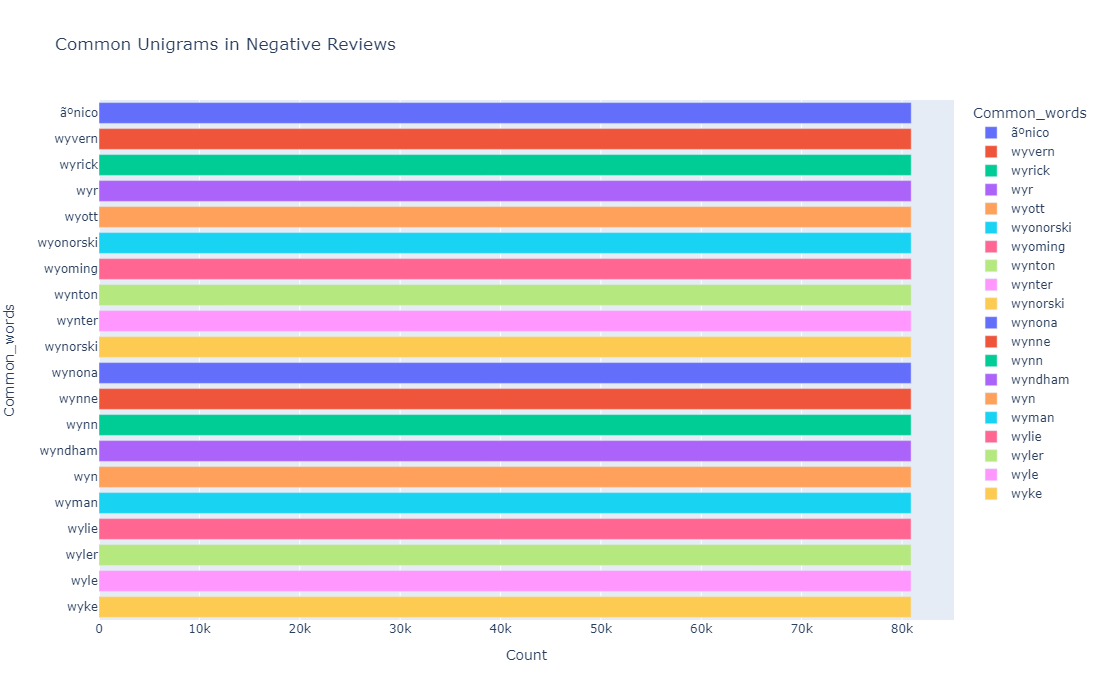

In [184]:
most_common_uni = get_top_text_ngrams(df.Reviews[df['Ratings']<=4],20,1)
temp=pd.DataFrame(most_common_uni).reset_index()
temp.columns=["Common_words", "Count"]
fig = px.bar(temp, x="Count", y='Common_words', 
             title='Common Unigrams in Negative Reviews', 
             orientation = 'h',
             width = 700,
            height = 700,
            color = 'Common_words')
fig.show()

In [185]:
df['Reviews'] = df['Reviews'].str.replace('ãºnico', '')

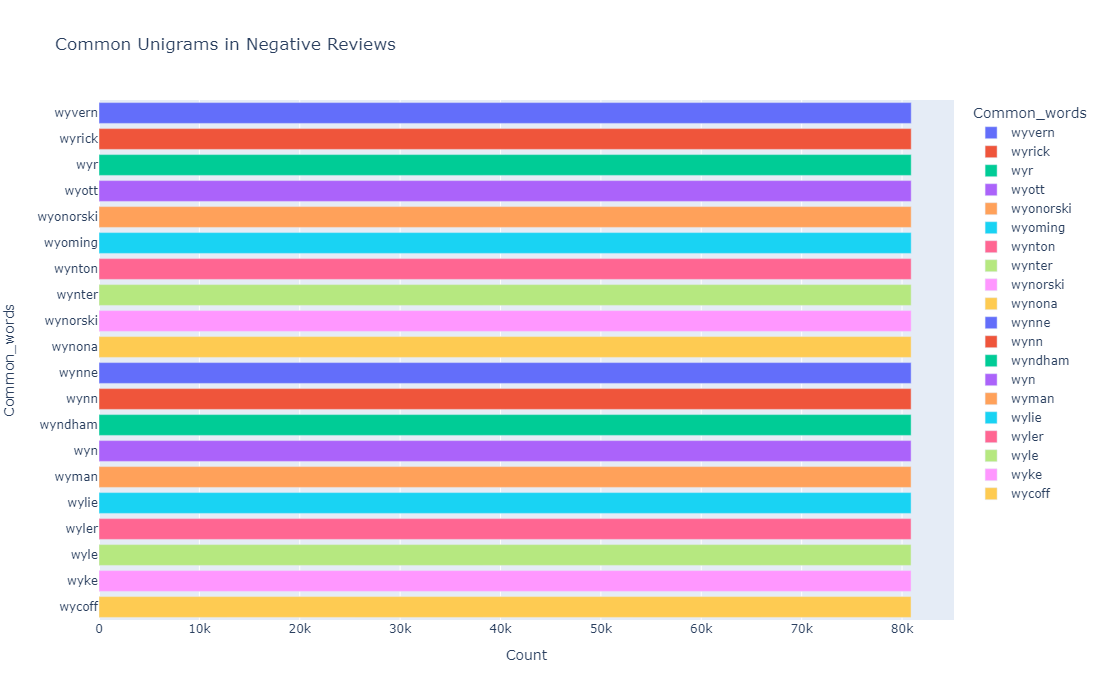

In [186]:
most_common_uni = get_top_text_ngrams(df.Reviews[df['Ratings']<=4],20,1)
temp=pd.DataFrame(most_common_uni).reset_index()
temp.columns=["Common_words", "Count"]
fig = px.bar(temp, x="Count", y='Common_words', 
             title='Common Unigrams in Negative Reviews', 
             orientation = 'h',
             width = 700,
            height = 700,
            color = 'Common_words')
fig.show()

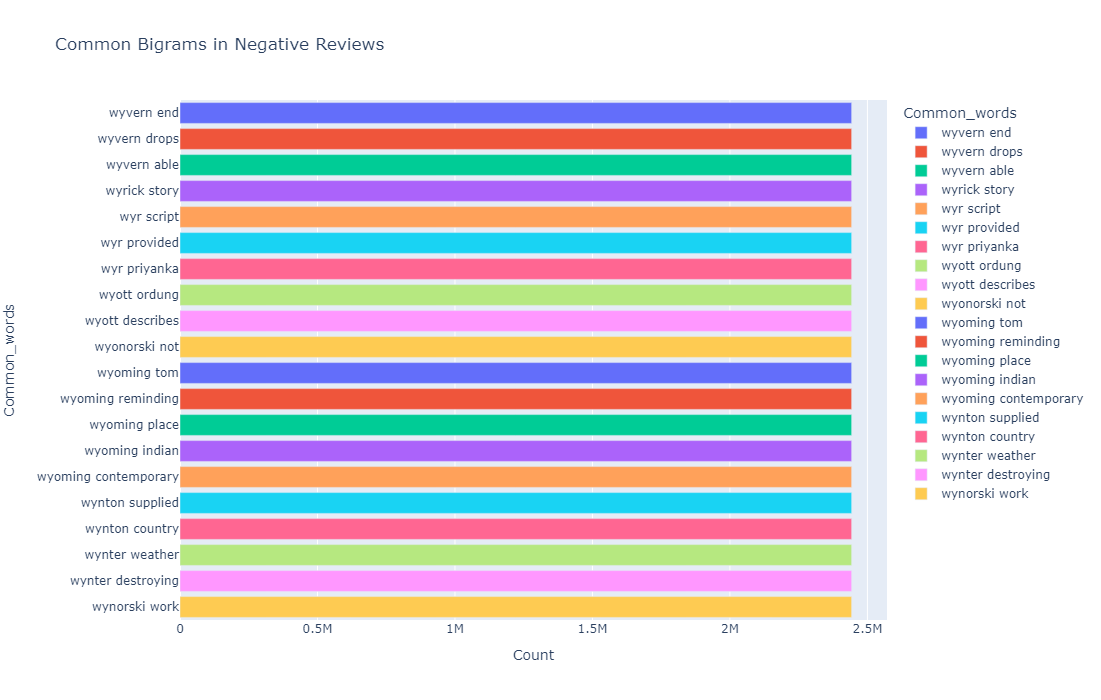

In [187]:
most_common_uni = get_top_text_ngrams(df.Reviews[df['Ratings']<=4],20,2)
temp=pd.DataFrame(most_common_uni).reset_index()
temp.columns=["Common_words", "Count"]
fig = px.bar(temp, x="Count", y='Common_words', 
             title='Common Bigrams in Negative Reviews', 
             orientation = 'h',
             width = 700,
            height = 700,
            color = 'Common_words')
fig.show()

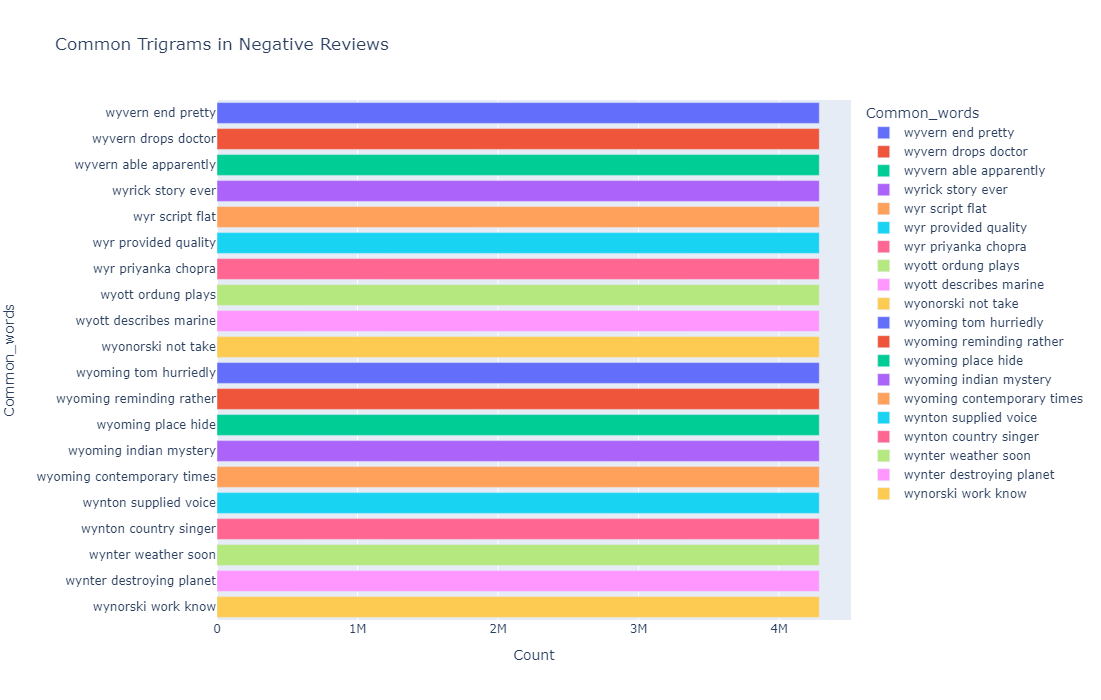

In [188]:
most_common_uni = get_top_text_ngrams(df.Reviews[df['Ratings']<=4],20,3)
temp=pd.DataFrame(most_common_uni).reset_index()
temp.columns=["Common_words", "Count"]
fig = px.bar(temp, x="Count", y='Common_words', 
             title='Common Trigrams in Negative Reviews', 
             orientation = 'h',
             width = 700,
            height = 700,
            color = 'Common_words')
fig.show()

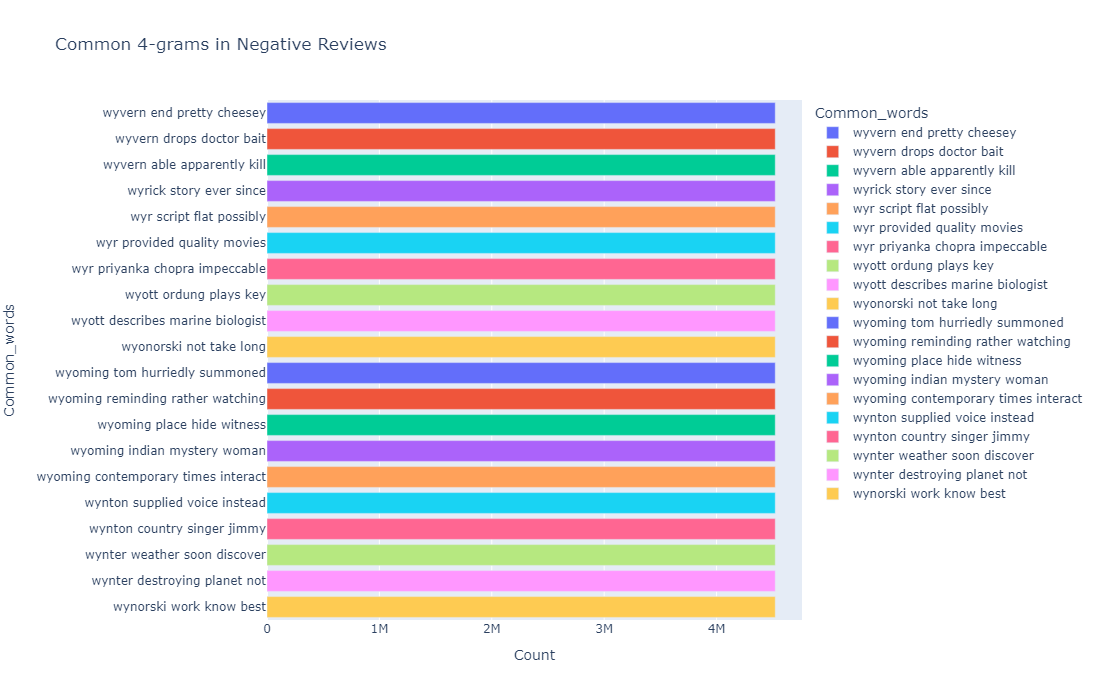

In [189]:
most_common_uni = get_top_text_ngrams(df.Reviews[df['Ratings']<=4],20,4)
temp=pd.DataFrame(most_common_uni).reset_index()
temp.columns=["Common_words", "Count"]
fig = px.bar(temp, x="Count", y='Common_words', 
             title='Common 4-grams in Negative Reviews', 
             orientation = 'h',
             width = 700,
            height = 700,
            color = 'Common_words')
fig.show()

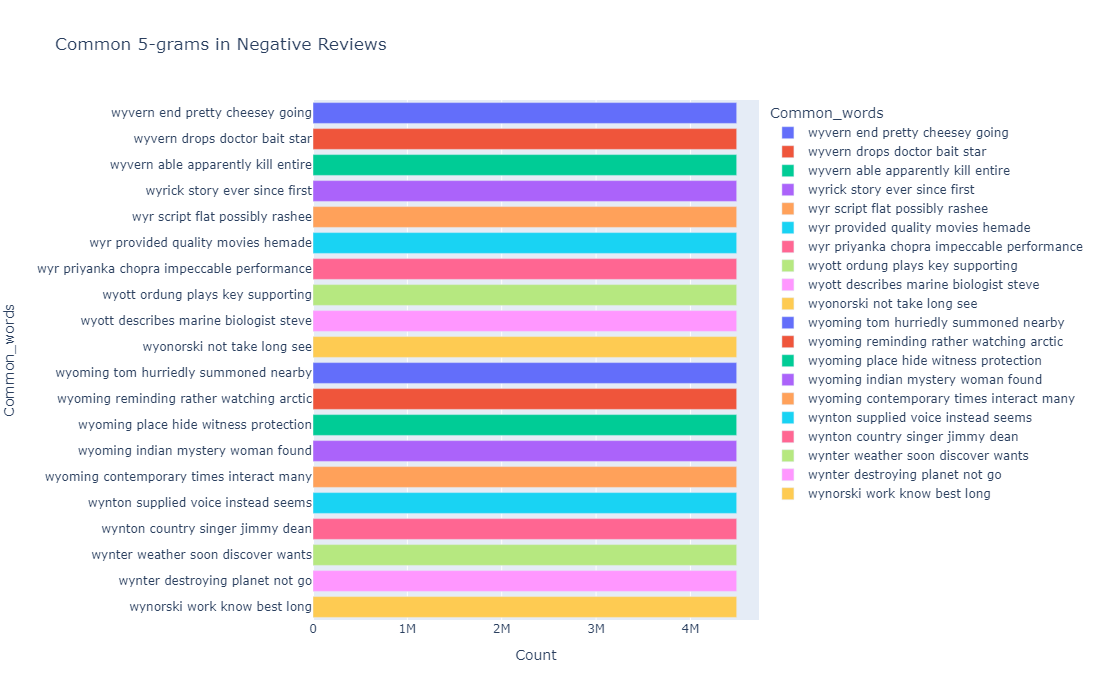

In [190]:
most_common_uni = get_top_text_ngrams(df.Reviews[df['Ratings']<=4],20,5)
temp=pd.DataFrame(most_common_uni).reset_index()
temp.columns=["Common_words", "Count"]
fig = px.bar(temp, x="Count", y='Common_words', 
             title='Common 5-grams in Negative Reviews', 
             orientation = 'h',
             width = 700,
            height = 700,
            color = 'Common_words')
fig.show()

In [191]:
pd.options.display.max_colwidth = 1000
df[['Reviews', 'Ratings', 'Movies']][(df['Ratings']<=4)&(df['Reviews'].str.contains('good|great'))].head()

Reviews  \
3   saw previous spoof movies two horrible know already tell want watch brainless person meant stereotypical laugh judge even automatically never ask comes two good old hollywood days whenever making showing people type also story kept edge well whenever word hit making films earned loads greedy people came picture quite two still artists notably genius christopher two guys ihave writing big let put simple terms guys not instead money craving latest proves even fails easily mind mean nothing funny people usually put best stuff idiots knew going made bet not good idea write reviews paper tell everyone whats good whats flipped review well warning not even called nothing artistic references made throughout pretty much like hannah montana juno gig actually close spoofing failed referencing instead joking twisting random wrestling not know high respect high respect know not something not add story nudity not really needed closest still wouldhave gotten idea saw bare hate girl says guys perv...   
6                                                                                                                                                                                                                                                                                                                                                                given free ticket not complain ripped minutes life irretrievably stolen sort movies epic meet not funny time reached new not real laugh anywhere alleged actually considerable amount stuff form especially garbage along ample helpings juvenile none actors even bothering put pretense nothing even mildly intelligent going entire beginning end utterly humorless human know past sort trash made enough money keep seltzer et grinding may downfall utter contempt seltzer collaborators audience finally beginning show fails saw almost empty theater good chance seltzer go back drawing stop making lazy finally develop real sense unfunny piece puke stay away   
7                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                not imaginative barb not shred wit saw friend said trailer free think spoof disaster movies not couple disaster movies get not really recent movies aspects current current women wrestling anything minute running time get nicole parker seems like good   
11                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           decided go see hoping bad become cant take kid confirmed jb ego even bigger kayne entire talented singer good simply nothing not forgot mention mommies fat cigar smoking managers made make look buried starting think don

In [192]:
pd.options.display.max_colwidth = 1000
df[['Reviews', 'Ratings', 'Movies']][(df['Ratings']<=4)&(df['Reviews'].str.contains('saturday night friday'))].head()

Reviews  \
7055   star saturday night friday night friday morning sunday night monday morning stars end days made tv biopic pop icon britney spears starting breakthrough single baby time shoved limelight pushy mother lynne domineering manager larry rudolph naively thought old mature enough handle massive media exposure pushed lie virginity keep trials turbulence relationships justin timberlake kevin federline revealing documentary something give really bad still feel utterly compelled see instinct tell looks really see end bad almost write review even seen still still interested subject matter see ihave never massive fan something britney spears always captivated kept icon popular culture ihave never gotten feeling comfortable dramatisation inevitable never something thought happy definitely case popular name big studio quite willingly thrown clout behind production budget monstrosity even existence ripe little budget must terrible production values evidence opening like crashing plane whirling beco...   
17427                                                                                                                                                               star saturday night friday night friday morning sunday night monday morningwill new guy high stands prime target soon makes friends jay simon neil three social misfits not complete dorks far coolest kids always spurs brit something home grown becomes imagine probably anyone small country not centre world sad thing sign times way tell massive success americans go remake almost whole lot best way describe inbetweeners usa imagine read really great stephen king see adaptation like really everything already seen british done american actors not even half bloody cultural slang becomes evident painful showcases insincere mess whole thing add insult performers not even look like british counter overweight hippie like neil simon resembling jonas not even respect source material biggest type rather drive mondeo definitely imagine different   
17818                                                                                                                                                                                                                                                                                                                                                                                                                                                                           star saturday night friday night friday morning sunday night monday morning premise behind abysmal action thriller group people going good old bit paint find really fighting stay alive barrage real bullets fired characters never developed explored impossible care needless air tension suspense acting bad none life though running around shouting screaming incoherently gives not anything special see usual generic stereotypes typical another not learned modern trend shaking camera around darkening lens putting annoying rather endearing flee   
18138                                                                                                                                                                                                                                                                                                                                                                                                                                                     star saturday night friday night friday morning sunday night monday morning go great pains write depth review last hard write much summary right opening lead characters wondering around deserted london shouting like aforementioned feels like pale imitation almost director knew practically copying scene scene gave bothering tell sort decent story goes motions post apocalyptic thriller usual set without firmly establishing back story behind majority humanity wiped making baffling danny dyer role sort blood crazed 

### Feature Engineering

In [193]:
df['Label'] = df['Ratings'].apply(lambda x: '1' if x>=7 else ('0' if x<=4 else '2'))
#Removing neutral portion
df = df[df.Label<'2']
data = df[['Reviews', 'Ratings', 'Label']]
print(data['Label'].value_counts())

Label
0    60000
1    60000
Name: count, dtype: int64


In [53]:
#There is no clas imbalance.

In [54]:
#df['Label'] = df['Label'].astype('category')

In [194]:
import sys
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from prettytable import PrettyTable

#### Lemmatization

In [195]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wordnetlemma = WordNetLemmatizer()
    def __call__(self, reviews):
        return[self.wordnetlemma.lemmatize(word) for word in word_tokenize(reviews)]
    

#### Vectorization with Count & TFIDF Vectorizer with unigram

In [26]:
%%time
train, test = train_test_split(data, test_size=0.3, random_state=42, shuffle=True)
countvect = CountVectorizer(analyzer='word', tokenizer=LemmaTokenizer(), ngram_range=(1,1), min_df=10, max_features=500)
tfidfvect = TfidfVectorizer(analyzer='word', tokenizer=LemmaTokenizer(), ngram_range=(1,1), min_df=10, max_features=500)
x_train_count = countvect.fit_transform(train['Reviews']).toarray()
x_test_count = countvect.transform(test['Reviews']).toarray()
x_train_tfidf = tfidfvect.fit_transform(train['Reviews']).toarray()
x_test_tfidf = tfidfvect.transform(test['Reviews']).toarray()
y_train = train['Label']
y_test = test['Label']

CPU times: total: 3min 54s
Wall time: 4min 38s


#### Feature importance with Logistic Regression & Count Vectorizer with unigram

In [58]:
%%time
lgr = LogisticRegression()
lgr.fit(x_train_count, y_train)
lgr.score(x_test_count, y_test)
lgr.coef_
i=0
importantfeature = PrettyTable(["Feature", "Score"])
for feature, importance in zip(countvect.get_feature_names_out(), lgr.coef_[0]):
    if i<=200:
        importantfeature.add_row([feature, importance])
        i=i+1
print(importantfeature)

+----------------+------------------------+
|    Feature     |         Score          |
+----------------+------------------------+
|      able      |  0.08241148688327019   |
|   absolutely   |  0.02871986907905017   |
|     across     |  -0.04518303349440283  |
|      act       |  -0.1494362912346173   |
|     acting     |  -0.18546590740947244  |
|     action     |  0.26933512406631216   |
|     actor      |  -0.13261571909833028  |
|    actress     |  -0.13532642253668203  |
|     actual     |  -0.1538200746844968   |
|    actually    |  -0.03634920990401527  |
|      add       |  0.03213697792665296   |
|      age       |  0.038784527512422215  |
|     alien      |  -0.0814341653998751   |
|     almost     |  -0.01247853333538968  |
|     along      |   0.1497396942691592   |
|    already     |  -0.1889312421086461   |
|      also      |  0.10675741554550904   |
|    although    |  0.21837100225252346   |
|     always     |   0.1995960496995316   |
|    amazing     |   0.890231006

#### Feature importance with Logistic Regression & TFIDF Vectorizer with unigram

In [59]:
lgr = LogisticRegression()
lgr.fit(x_train_tfidf, y_train)
lgr.score(x_test_tfidf, y_test)
lgr.coef_
i=0
importantfeature = PrettyTable(["Feature", "Score"])
for feature, importance in zip(tfidfvect.get_feature_names_out(), lgr.coef_[0]):
    if i<=100:
        importantfeature.add_row([feature, importance])
        i=i+1
print(importantfeature)

+----------------+-----------------------+
|    Feature     |         Score         |
+----------------+-----------------------+
|      able      |  0.40489836309949506  |
|   absolutely   |   0.2664222997920392  |
|     across     |  -0.1300472805736832  |
|      act       |  -0.8970567790006645  |
|     acting     |  -1.4050435879558265  |
|     action     |   2.2483841098635056  |
|     actor      |  -1.1623114127448713  |
|    actress     |  -0.8489618147880299  |
|     actual     |  -0.8676093857954498  |
|    actually    |  -0.2810698549315754  |
|      add       |  0.23607292096804278  |
|      age       |   0.5695015911722441  |
|     alien      |  -0.29969380157421344 |
|     almost     |  -0.1912642889904209  |
|     along      |   0.863335111327255   |
|    already     |  -0.9993211714920999  |
|      also      |   1.214344473453655   |
|    although    |   1.2664554900402767  |
|     always     |   1.5425868496668365  |
|    amazing     |   4.255213162001716   |
|    americ

#### Vectorization with Count & TFIDF Vectorizer with bigram

In [29]:
%%time
train, test = train_test_split(data, test_size=0.3, random_state=42, shuffle=True)
countvect = CountVectorizer(analyzer='word', tokenizer=LemmaTokenizer(), ngram_range=(2,2), min_df=10, max_features=500)
tfidfvect = TfidfVectorizer(analyzer='word', tokenizer=LemmaTokenizer(), ngram_range=(2,2), min_df=10, max_features=500)
x_train_count = countvect.fit_transform(train['Reviews']).toarray()
x_test_count = countvect.transform(test['Reviews']).toarray()
x_train_tfidf = tfidfvect.fit_transform(train['Reviews']).toarray()
x_test_tfidf = tfidfvect.transform(test['Reviews']).toarray()
y_train = train['Label']
y_test = test['Label']

CPU times: total: 6min 41s
Wall time: 7min 42s


#### Feature importance with Logistic Regression & Count Vectorizer with Bigram

In [30]:
lgr = LogisticRegression()
lgr.fit(x_train_count, y_train)
lgr.score(x_test_count, y_test)
lgr.coef_
i=0
importantfeature = PrettyTable(["Feature", "Score"])
for feature, importance in zip(countvect.get_feature_names_out(), lgr.coef_[0]):
    if i<=200:
        importantfeature.add_row([feature, importance])
        i=i+1
print(importantfeature)

+-----------------------+-----------------------+
|        Feature        |         Score         |
+-----------------------+-----------------------+
|   absolutely nothing  |  -1.4223783115528383  |
|     academy award     |   0.7259991527221106  |
|        act like       |  -0.5342853134812416  |
|      acting good      |   0.6326990735577867  |
|       acting not      |  -0.4388127900703859  |
|      action movie     |   0.6828458506221183  |
|       action not      |   0.3956484459851199  |
|      action scene     |  0.34474379908538805  |
|    action sequence    |   0.2751925687604629  |
|     actor actress     |  -0.02688450661736038 |
|       actor not       |  -0.41744822068361126 |
|      actually not     |  -0.0874872392768863  |
|    actually pretty    |  0.10971541393130708  |
|     actually quite    |  0.04094746749424956  |
|      adam sandler     |  0.34503075356245794  |
|         ai not        |  0.027950453975489613 |
|      almost every     |  -0.11943621351206948 |


#### Feature importance with Logistic Regression & TFIDF Vectorizer with Bigram

In [31]:
lgr = LogisticRegression()
lgr.fit(x_train_tfidf, y_train)
lgr.score(x_test_tfidf, y_test)
lgr.coef_
i=0
importantfeature = PrettyTable(["Feature", "Score"])
for feature, importance in zip(tfidfvect.get_feature_names_out(), lgr.coef_[0]):
    if i<=100:
        importantfeature.add_row([feature, importance])
        i=i+1
print(importantfeature)

+-----------------------+------------------------+
|        Feature        |         Score          |
+-----------------------+------------------------+
|   absolutely nothing  |  -2.7316763327285876   |
|     academy award     |   1.166637556615573    |
|        act like       |   -1.202767257567583   |
|      acting good      |   1.195432650971522    |
|       acting not      |   -1.098794655653214   |
|      action movie     |   1.383035056275852    |
|       action not      |   0.7050941745356389   |
|      action scene     |   0.7105617337762972   |
|    action sequence    |   0.5538162271798281   |
|     actor actress     |  -0.19040430375076317  |
|       actor not       |  -0.9692522838172228   |
|      actually not     |  -0.35154957165876655  |
|    actually pretty    |  0.21345793179467631   |
|     actually quite    |  0.09740111450654416   |
|      adam sandler     |   0.9916601741771649   |
|         ai not        |  -0.02750463085103927  |
|      almost every     |  -0.2

In [196]:
pd.options.display.max_colwidth = 1000
df[['Reviews', 'Ratings', 'Movies']][(df['Ratings']>=9)&(df['Reviews'].str.contains('bad review'))].head()

Reviews  \
120047                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       not call greatest ever not anywhere near bad reviewers made average rating stars harsh totally terror feels like episode twilight stretched much like tv show wonders not originally created fan series like step tales alfred hitchcock likely find pleasant way spend give others panning giving   
120239                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     idea many bad reviews loved thought advanced thoughtful graphic comparison video game culture girl culture spot makes connections ihave never seen big screen see every day casting spot hello girls supposed little wish directors take color consideration way highly stylized sets make murder scenes believable everything live not social media someone explain   
120334  not understand negative reviews deserve definitely wrong people not care positive message beyond touch shows happen person influence change boys not see promising streets not fair try understand not raised bad still totally get sacrifices many lessons based real life many people however fate made entrance boys brought someone made believe whether dance art true creative minds get art dance comes many not know see stereotypical not think exploited reviews voicing opinion point making not understand mindset stayed stuck parts little boys kids street people giving bad reviews using half consider good positive element opportunity make productive get positive frame mind greatest part not realistic clearly missing point great positive not forget encouraging cannot see positive part outweigh touch generation people enjoy kind need dance part keeping occupied marques done exceptional watch nieces nephews many times keep collection good applaud message leave close minded people quote albert...   
120408                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  watch cool enough stuff think coming horror entitled war usually look forward movies w bad reviewsso please keep giving cool movies like poor old timers made cool adrianne still kicks funny reading suggest watching thank horror movies real cool movies like made people need give poor reviews 

#### Vectorization with Count & TFIDF Vectorizer with Trigram

In [64]:
%%time
train, test = train_test_split(data, test_size=0.3, random_state=42, shuffle=True)
countvect = CountVectorizer(analyzer='word', tokenizer=LemmaTokenizer(), ngram_range=(3,3), min_df=10, max_features=500)
tfidfvect = TfidfVectorizer(analyzer='word', tokenizer=LemmaTokenizer(), ngram_range=(3,3), min_df=10, max_features=500)
x_train_count = countvect.fit_transform(train['Reviews']).toarray()
x_test_count = countvect.transform(test['Reviews']).toarray()
x_train_tfidf = tfidfvect.fit_transform(train['Reviews']).toarray()
x_test_tfidf = tfidfvect.transform(test['Reviews']).toarray()
y_train = train['Label']
y_test = test['Label']

CPU times: total: 8min 19s
Wall time: 8min 43s


#### Feature importance with Logistic Regression & Count Vectorizer with Trigram

In [65]:
lgr = LogisticRegression()
lgr.fit(x_train_count, y_train)
lgr.score(x_test_count, y_test)
lgr.coef_
i=0
importantfeature = PrettyTable(["Feature", "Score"])
for feature, importance in zip(countvect.get_feature_names_out(), lgr.coef_[0]):
    if i<=200:
        importantfeature.add_row([feature, importance])
        i=i+1
print(importantfeature)

+---------------------------+-----------------------+
|          Feature          |         Score         |
+---------------------------+-----------------------+
|       acting not bad      |   -0.406779172493347  |
|      acting not even      |  -1.7885741064278875  |
|      acting not good      |  -1.4790002115137597  |
|     acting pretty good    |   0.6321968359910299  |
|   acting special effect   |  -0.44661843084223113 |
|      action scene not     |  -0.2108461912916113  |
|     action take place     |  0.02201411203098805  |
|       actor good job      |   0.6073460484700091  |
|      actor look like      |  -1.0479314967750024  |
|      actually not bad     |   -0.556456126729881  |
|    actually pretty good   |   0.3543113578257702  |
|     almost every scene    |  -0.1378807764661741  |
|      almost feel like     |   0.5576465944576114  |
|        bad bad bad        |   -1.868454167184033  |
|        bad guy not        |  0.14927481499041267  |
|        bad not even       

#### Feature importance with Logistic Regression & TFIDF Vectorizer with Trigram

In [66]:
lgr = LogisticRegression()
lgr.fit(x_train_tfidf, y_train)
lgr.score(x_test_tfidf, y_test)
lgr.coef_
i=0
importantfeature = PrettyTable(["Feature", "Score"])
for feature, importance in zip(tfidfvect.get_feature_names_out(), lgr.coef_[0]):
    if i<=100:
        importantfeature.add_row([feature, importance])
        i=i+1
print(importantfeature)

+---------------------------+----------------------+
|          Feature          |        Score         |
+---------------------------+----------------------+
|       acting not bad      | -0.4561939510659875  |
|      acting not even      |  -2.105345945593677  |
|      acting not good      | -1.6618603873848936  |
|     acting pretty good    |  0.6901750287605112  |
|   acting special effect   | -0.5230235833622688  |
|      action scene not     | -0.19669191158762198 |
|     action take place     | 0.014659990997988237 |
|       actor good job      |  0.5980184862856086  |
|      actor look like      | -1.1721686509241185  |
|      actually not bad     | -0.6041812395230495  |
|    actually pretty good   |  0.3397834340072055  |
|     almost every scene    | -0.15107138208360926 |
|      almost feel like     |  0.5967610356761408  |
|        bad bad bad        |  -2.615607884373221  |
|        bad guy not        |  0.2279203212390423  |
|        bad not even       |  -2.208642147983

#### Vectorization with Count & TFIDF Vectorizer with 4-gram

In [67]:
%%time
train, test = train_test_split(data, test_size=0.3, random_state=42, shuffle=True)
countvect = CountVectorizer(analyzer='word', tokenizer=LemmaTokenizer(), ngram_range=(4,4), min_df=10, max_features=500)
tfidfvect = TfidfVectorizer(analyzer='word', tokenizer=LemmaTokenizer(), ngram_range=(4,4), min_df=10, max_features=500)
x_train_count = countvect.fit_transform(train['Reviews']).toarray()
x_test_count = countvect.transform(test['Reviews']).toarray()
x_train_tfidf = tfidfvect.fit_transform(train['Reviews']).toarray()
x_test_tfidf = tfidfvect.transform(test['Reviews']).toarray()
y_train = train['Label']
y_test = test['Label']

CPU times: total: 8min 9s
Wall time: 8min 43s


#### Feature importance with Logistic Regression & Count Vectorizer with 4-gram

In [68]:
lgr = LogisticRegression()
lgr.fit(x_train_count, y_train)
lgr.score(x_test_count, y_test)
lgr.coef_
i=0
importantfeature = PrettyTable(["Feature", "Score"])
for feature, importance in zip(countvect.get_feature_names_out(), lgr.coef_[0]):
    if i<=200:
        importantfeature.add_row([feature, importance])
        i=i+1
print(importantfeature)

+------------------------------------------------+-----------------------+
|                    Feature                     |         Score         |
+------------------------------------------------+-----------------------+
|         actually character soul better         |  0.035535021870107875 |
|     addictive consistently compelling show     |  0.09395521436725546  |
|        adjective describe good writing         |  0.035535021870107875 |
|                 ai not gon na                  |  -0.7015052017358362  |
|             also great also great              |  0.37827324015076674  |
|      always natural layered demonstrates       |  0.035535021870107875 |
|       annoying illogical decision making       |  -0.03311545773284919 |
|         another seen hence reiteration         | -0.047905207167646936 |
|   appreciation frequent personal experience    |  -0.1512446881529819  |
|          atmosphere due excessive lot          | -0.030689126161214244 |
|         atmospheric bea

#### Feature importance with Logistic Regression & TFIDF Vectorizer with 4-gram

In [69]:
lgr = LogisticRegression()
lgr.fit(x_train_tfidf, y_train)
lgr.score(x_test_tfidf, y_test)
lgr.coef_
i=0
importantfeature = PrettyTable(["Feature", "Score"])
for feature, importance in zip(tfidfvect.get_feature_names_out(), lgr.coef_[0]):
    if i<=100:
        importantfeature.add_row([feature, importance])
        i=i+1
print(importantfeature)

+---------------------------------------------+----------------------+
|                   Feature                   |        Score         |
+---------------------------------------------+----------------------+
|        actually character soul better       | 0.17234816260767954  |
|    addictive consistently compelling show   |  0.2643130484457764  |
|       adjective describe good writing       | 0.17234816260767954  |
|                ai not gon na                | -0.6586464210709307  |
|            also great also great            |  0.770523740526644   |
|     always natural layered demonstrates     | 0.17234816260767954  |
|      annoying illogical decision making     | -0.2130022048037178  |
|        another seen hence reiteration       | -0.25036094262212627 |
|  appreciation frequent personal experience  | -0.3276635457130833  |
|         atmosphere due excessive lot        | -0.19271953403391096 |
|        atmospheric beautiful eye real       |  0.2643130484457764  |
| atmo

#### Vectorization with Count & TFIDF Vectorizer with unigram, bigram & trigram

In [197]:
%%time
train, test = train_test_split(data, test_size=0.3, random_state=42, shuffle=True)
countvect = CountVectorizer(analyzer='word', tokenizer=LemmaTokenizer(), ngram_range=(1,3), min_df=10, max_features=500)
tfidfvect = TfidfVectorizer(analyzer='word', tokenizer=LemmaTokenizer(), ngram_range=(1,3), min_df=10, max_features=500)
x_train_count = countvect.fit_transform(train['Reviews']).toarray()
x_test_count = countvect.transform(test['Reviews']).toarray()
x_train_tfidf = tfidfvect.fit_transform(train['Reviews']).toarray()
x_test_tfidf = tfidfvect.transform(test['Reviews']).toarray()
y_train = train['Label']
y_test = test['Label']

CPU times: total: 11min 10s
Wall time: 15min 2s


#### Feature Selection using Chi-Squared

In [198]:
from sklearn.feature_selection import chi2
from os.path import join

In [199]:
%%time
N=5000
Number = 1
featureselection = PrettyTable(['Unigram', 'Bigram', 'Trigram'])
for category in train['Label'].unique():
    features_chi2 = chi2(x_train_tfidf, train['Label']==category)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidfvect.get_feature_names_out())[indices]
    unigrams = [x for x in feature_names if len(x.split(' '))==1]
    bigrams = [x for x in feature_names if len(x.split(' '))==2]
    trigrams = [x for x in feature_names if len(x.split(' '))==3]
    print("%s. %s : " % (Number, category))
    print("\t# Unigrams :\n\t. %s" %('\n\t. '.join(unigrams[-N:])))
    print("\t# Bigrams :\n\t. %s" %('\n\t. '.join(bigrams[-N:])))
    print("\t# Trigrams :\n\t. %s" %('\n\t. '.join(trigrams[-N:])))
    Number = Number+1

1. 1 : 
	# Unigrams :
	. major
	. main
	. came
	. due
	. known
	. took
	. three
	. usually
	. credit
	. level
	. early
	. evil
	. extremely
	. flick
	. seen
	. huge
	. anyone
	. looking
	. away
	. tell
	. matter
	. wish
	. remember
	. behind
	. person
	. however
	. long
	. particularly
	. despite
	. close
	. soon
	. know
	. dvd
	. knew
	. ihave
	. opening
	. two
	. somewhat
	. home
	. want
	. order
	. blood
	. watch
	. voice
	. done
	. watched
	. lead
	. begin
	. number
	. going
	. later
	. scary
	. perhaps
	. feature
	. say
	. heard
	. men
	. high
	. becomes
	. turn
	. place
	. black
	. kind
	. much
	. everything
	. direction
	. face
	. sequence
	. need
	. directed
	. pretty
	. gore
	. playing
	. version
	. sequel
	. come
	. rating
	. fight
	. sense
	. interesting
	. saying
	. gave
	. death
	. ending
	. hero
	. add
	. kid
	. car
	. screen
	. stuff
	. slow
	. actress
	. character
	. small
	. amount
	. stop
	. second
	. every
	. original
	. special
	. across
	. put
	. felt
	. went
	. mo

### Model Selection

In [200]:
import scipy as sp
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

#### Logistic regression Model

In [37]:
model_1 = Pipeline(
    steps=[
        ("classifier", LogisticRegression())]
)

#### Training of Logistic Regression Model

In [38]:
%%time
model_1.fit(x_train_tfidf, y_train)

CPU times: total: 11.7 s
Wall time: 4.63 s


Pipeline(steps=[('classifier', LogisticRegression())])

#### Evaluation on Test and train Dataset

In [39]:
%%time
print("Precision score on training dataset for Logistic Regression: %s" % precision_score(y_train, model_1.predict(x_train_tfidf), average='micro'))
#print("AUC score on training dataset for Logistic Regression: %s" % roc_auc_score(y_train, model_1.predcit_proba(x_train_tfidf)[:,1],multi_class='ovo', average='macro'))
f1_score_train_1 = f1_score(y_train, model_1.predict(x_train_tfidf), average="weighted")
print("F1 score on training dataset for Logistic Regression: %s" % f1_score_train_1)
print("Precision score on test dataset for Logistic Regression: %s" % precision_score(y_test, model_1.predict(x_test_tfidf), average='micro'))
#print("AUC score on test dataset for Logistic Regression: %s" % roc_auc_score(y_test, model_1.predict_proba(x_test_tfidf)[:,1], multi_class='ovo', average='macro'))
f1_score_1 = f1_score(y_test, model_1.predict(x_test_tfidf), average="weighted")
print("F1 score for Logistic Regression: " % f1_score_1)

Precision score on training dataset for Logistic Regression: 0.8213928571428571
F1 score on training dataset for Logistic Regression: 0.8213819709287489
Precision score on test dataset for Logistic Regression: 0.8136944444444445
F1 score for Logistic Regression: 
CPU times: total: 6.78 s
Wall time: 5.75 s


#### Decision Tree Classifier

In [40]:
model_2 = Pipeline(
    steps=["classifier", DecisionTreeClassifier(criterion='gini')]
)

#### Training of Decision Tree Classifier

In [78]:
%%time
#model_2.fit(x_train_tfidf, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


In [79]:
#model_2 won't work on this huge dataset so we won't be considering it our selection process.

In [41]:
model_3 = Pipeline(
    steps = [
        ("classifier", DecisionTreeClassifier(criterion='gini', max_depth=11, min_samples_split=2,  min_samples_leaf=1))
    ]
)

In [42]:
%%time
model_3.fit(x_train_tfidf,y_train)

CPU times: total: 23.1 s
Wall time: 24.8 s


Pipeline(steps=[('classifier', DecisionTreeClassifier(max_depth=11))])

In [43]:
%%time
print("Precision Score on training dateset for Decision Tree Classifier: %s" % precision_score(y_train,model_3.predict(x_train_tfidf),average='micro'))
print("AUC Score on training dateset for Decision Tree Classifier: %s" % roc_auc_score(y_train,model_3.predict_proba(x_train_tfidf)[:,1],multi_class='ovo',average='macro'))
f1_score_train_3 =f1_score(y_train,model_3.predict(x_train_tfidf),average="weighted")
print("F1 Score training dateset for Decision Tree Classifier: %s" % f1_score_train_3)
print("Precision Score on test for Decision Tree Classifier: %s" % precision_score(y_test,model_3.predict(x_test_tfidf),average='micro'))
print("AUC Score on test for Decision Tree Classifier: %s" % roc_auc_score(y_test,model_3.predict_proba(x_test_tfidf)[:,1],multi_class='ovo',average='macro'))
f1_score_3 =f1_score(y_test,model_3.predict(x_test_tfidf),average="weighted")
print("F1 Score for Decision Tree Classifier: %s" % f1_score_3)

Precision Score on training dateset for Decision Tree Classifier: 0.7156190476190476
AUC Score on training dateset for Decision Tree Classifier: 0.8045401027361847
F1 Score training dateset for Decision Tree Classifier: 0.711966950947821
Precision Score on test for Decision Tree Classifier: 0.6855
AUC Score on test for Decision Tree Classifier: 0.7561645102205606
F1 Score for Decision Tree Classifier: 0.6812120963091436
CPU times: total: 6.08 s
Wall time: 6.6 s


#### Random Forest Classifier

In [44]:
model_4 = Pipeline(
    steps=[
        ("classifier", RandomForestClassifier())
    ]
)

In [45]:
%%time
model_4.fit(x_train_tfidf, y_train)

CPU times: total: 4min 16s
Wall time: 4min 34s


Pipeline(steps=[('classifier', RandomForestClassifier())])

In [46]:
%%time
print("Precision Score on training dateset for Random Forest Classifier: %s" % precision_score(y_train,model_4.predict(x_train_tfidf),average='micro'))
print("AUC Score on training dateset for Random Forest Classifier: %s" % roc_auc_score(y_train,model_4.predict_proba(x_train_tfidf)[:,1],multi_class='ovo',average='macro'))
f1_score_train_4 =f1_score(y_train,model_4.predict(x_train_tfidf),average="weighted")
print("F1 Score training dateset for Random Forest Classifier: %s" % f1_score_train_4)
print("Precision Score on test for Random Forest Classifier: %s" % precision_score(y_test,model_4.predict(x_test_tfidf),average='micro'))
print("AUC Score on test for Random Forest Classifier: %s" % roc_auc_score(y_test,model_4.predict_proba(x_test_tfidf)[:,1],multi_class='ovo',average='macro'))
f1_score_4 =f1_score(y_test,model_4.predict(x_test_tfidf),average="weighted")
print("F1 Score for Random Forest Classifier: %s" % f1_score_4)

Precision Score on training dateset for Random Forest Classifier: 0.9994047619047619
AUC Score on training dateset for Random Forest Classifier: 0.9999885038014157
F1 Score training dateset for Random Forest Classifier: 0.9994047627250797
Precision Score on test for Random Forest Classifier: 0.7892777777777777
AUC Score on test for Random Forest Classifier: 0.8706390149962466
F1 Score for Random Forest Classifier: 0.7892795988362674
CPU times: total: 32.1 s
Wall time: 33.5 s


#### Ada Boost Classifier

In [47]:
model_5 = Pipeline(
    steps = [
        ("classifier", AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=4), n_estimators=100, learning_rate=0.8))
    ]
)

In [48]:
%%time
model_5.fit(x_train_tfidf, y_train)

CPU times: total: 19min 7s
Wall time: 21min 53s


Pipeline(steps=[('classifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4),
                                    learning_rate=0.8, n_estimators=100))])

In [49]:
%%time
print("Precision Score on training dateset for Ada Boost Classifier: %s" % precision_score(y_train,model_5.predict(x_train_tfidf),average='micro'))
print("AUC Score on training dateset for Ada Boost Classifier: %s" % roc_auc_score(y_train,model_5.predict_proba(x_train_tfidf)[:,1],multi_class='ovo',average='macro'))
f1_score_train_5 =f1_score(y_train,model_5.predict(x_train_tfidf),average="weighted")
print("F1 Score training dateset for Ada Boost Classifier: %s" % f1_score_train_5)
print("Precision Score on test for Ada Boost Classifier: %s" % precision_score(y_test,model_5.predict(x_test_tfidf),average='micro'))
print("AUC Score on test for Ada Boost Classifier: %s" % roc_auc_score(y_test,model_5.predict_proba(x_test_tfidf)[:,1],multi_class='ovo',average='macro'))
f1_score_5 =f1_score(y_test,model_5.predict(x_test_tfidf),average="weighted")
print("F1 Score for Random Forest Classifier: %s" % f1_score_5)

Precision Score on training dateset for Ada Boost Classifier: 0.8477619047619047
AUC Score on training dateset for Ada Boost Classifier: 0.9330858123564605
F1 Score training dateset for Ada Boost Classifier: 0.8477593741744296
Precision Score on test for Ada Boost Classifier: 0.7897222222222222
AUC Score on test for Ada Boost Classifier: 0.8671511066923805
F1 Score for Random Forest Classifier: 0.7897263343867823
CPU times: total: 1min 27s
Wall time: 1min 35s


### HyperParameter Tunning using Grid Search

In [28]:
def hyperparamtune(classifier, param_grid, metric, verbose_value, cv):
    model = model_selection.GridSearchCV(
        estimator = classifier,
        param_grid = param_grid,
        scoring = metric,
        verbose = verbose_value,
        cv = cv
    )
    model.fit(x_train_tfidf,y_train)
    print("Best score %s " % {model.best_score_})
    print("Best hyperparameter set: " )
    best_parameters = model.best_estimator_.get_params()
    for param_name in sorted(param_grid.keys()):
        print(f"\t{param_name}: {best_parameters[param_name]}")
    return model, best_parameters

#### Hyperparameter tunning of Logistic regression

In [53]:
model_7 = LogisticRegression(penalty='l2', C=1, max_iter=100, tol=0.0001)

In [54]:
%%time
model_7.fit(x_train_tfidf, y_train)

CPU times: total: 11.1 s
Wall time: 4.17 s


LogisticRegression(C=1)

#### Evaluation of Fine Tuned Logistic Regression Classifier

In [55]:
%%time
print("Precision Score on training dateset for Finetuned Logsitic Regression Classifier: %s" % precision_score(y_train,model_7.predict(x_train_tfidf),average='micro'))
print("AUC Score on training dateset for Finetuned Logsitic Regression Classifier: %s" % roc_auc_score(y_train,model_7.predict_proba(x_train_tfidf)[:,1],multi_class='ovo',average='macro'))
f1_score_train_7 =f1_score(y_train,model_7.predict(x_train_tfidf),average="weighted")
print("F1 Score training dateset for Finetuned Logsitic Regression Classifier: %s" % f1_score_train_7)
print("Precision Score on test for Finetuned Logsitic Regression Classifier: %s" % precision_score(y_test,model_7.predict(x_test_tfidf),average='micro'))
print("AUC Score on test for Finetuned Logsitic Regression Classifier: %s" % roc_auc_score(y_test,model_7.predict_proba(x_test_tfidf)[:,1],multi_class='ovo',average='macro'))
f1_score_7 =f1_score(y_test,model_7.predict(x_test_tfidf),average="weighted")
print("F1 Score for Finetuned Logsitic Regression Classifier: %s" % f1_score_7)

Precision Score on training dateset for Finetuned Logsitic Regression Classifier: 0.8213928571428571
AUC Score on training dateset for Finetuned Logsitic Regression Classifier: 0.9028265812701136
F1 Score training dateset for Finetuned Logsitic Regression Classifier: 0.8213819709287489
Precision Score on test for Finetuned Logsitic Regression Classifier: 0.8136944444444445
AUC Score on test for Finetuned Logsitic Regression Classifier: 0.8977487804591967
F1 Score for Finetuned Logsitic Regression Classifier: 0.8136964787157644
CPU times: total: 8.27 s
Wall time: 6.6 s


#### Hyperparameter Tunning for Random Forest Classifier

In [56]:
model_8 = RandomForestClassifier(criterion='entropy', max_depth=23, min_samples_leaf=5, min_samples_split=5, n_estimators=100)

In [57]:
%%time
model_8.fit(x_train_tfidf, y_train)

CPU times: total: 2min 53s
Wall time: 3min 15s


RandomForestClassifier(criterion='entropy', max_depth=23, min_samples_leaf=5,
                       min_samples_split=5)

#### Evaluation of Finetuned Random Forest Classifier

In [58]:
%%time
print("Precision Score on training dateset for Finetuned Random Forest Classifier: %s" % precision_score(y_train,model_8.predict(x_train_tfidf),average='micro'))
print("AUC Score on training dateset for Finetuned Random Forest Classifier: %s" % roc_auc_score(y_train,model_8.predict_proba(x_train_tfidf)[:,1],multi_class='ovo',average='macro'))
f1_score_train_8 =f1_score(y_train,model_8.predict(x_train_tfidf),average="weighted")
print("F1 Score training dateset for Finetuned Random Forest Classifier: %s" % f1_score_train_8)
print("Precision Score on test for Finetuned Random Forest Classifier: %s" % precision_score(y_test,model_8.predict(x_test_tfidf),average='micro'))
print("AUC Score on test for Finetuned Random Forest Classifier: %s" % roc_auc_score(y_test,model_8.predict_proba(x_test_tfidf)[:,1],multi_class='ovo',average='macro'))
f1_score_8 =f1_score(y_test,model_8.predict(x_test_tfidf),average="weighted")
print("F1 Score for Finetuned Random Forest Classifier: %s" % f1_score_8)

Precision Score on training dateset for Finetuned Random Forest Classifier: 0.8500119047619048
AUC Score on training dateset for Finetuned Random Forest Classifier: 0.9337031367915544
F1 Score training dateset for Finetuned Random Forest Classifier: 0.8499872345773573
Precision Score on test for Finetuned Random Forest Classifier: 0.7808333333333334
AUC Score on test for Finetuned Random Forest Classifier: 0.866389742522866
F1 Score for Finetuned Random Forest Classifier: 0.7808142597603579
CPU times: total: 21 s
Wall time: 21.6 s


#### Hyperparameter Tunning for Ada Boost Classifier

In [60]:
model_9 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), learning_rate=1, n_estimators=150)

In [61]:
%%time
model_9.fit(x_train_tfidf, y_train)

CPU times: total: 8min 28s
Wall time: 9min 36s


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=1, n_estimators=150)

#### Evaluation of Finetuned Ada Boost Classifier

In [62]:
%%time
print("Precision Score on training dateset for Finetuned Random Forest Classifier: %s" % precision_score(y_train,model_9.predict(x_train_tfidf),average='micro'))
print("AUC Score on training dateset for Finetuned Random Forest Classifier: %s" % roc_auc_score(y_train,model_9.predict_proba(x_train_tfidf)[:,1],multi_class='ovo',average='macro'))
f1_score_train_9 =f1_score(y_train,model_9.predict(x_train_tfidf),average="weighted")
print("F1 Score training dateset for Finetuned Random Forest Classifier: %s" % f1_score_train_9)
print("Precision Score on test for Finetuned Random Forest Classifier: %s" % precision_score(y_test,model_9.predict(x_test_tfidf),average='micro'))
print("AUC Score on test for Finetuned Random Forest Classifier: %s" % roc_auc_score(y_test,model_9.predict_proba(x_test_tfidf)[:,1],multi_class='ovo',average='macro'))
f1_score_9 =f1_score(y_test,model_9.predict(x_test_tfidf),average="weighted")
print("F1 Score for Finetuned Random Forest Classifier: %s" % f1_score_9)

Precision Score on training dateset for Finetuned Random Forest Classifier: 0.8050119047619048
AUC Score on training dateset for Finetuned Random Forest Classifier: 0.8892055760559792
F1 Score training dateset for Finetuned Random Forest Classifier: 0.8050078066958588
Precision Score on test for Finetuned Random Forest Classifier: 0.7980277777777778
AUC Score on test for Finetuned Random Forest Classifier: 0.8819000729687284
F1 Score for Finetuned Random Forest Classifier: 0.7980315054215822
CPU times: total: 2min 8s
Wall time: 2min 22s


### Model Selection

In [120]:
best_score = max(f1_score_1, f1_score_3, f1_score_4, f1_score_5, f1_score_7, f1_score_8, f1_score_9)

In [121]:
best_score

0.8136964787157644

In [128]:
if best_score==f1_score_1:
    model = model_1
    print("Logsitics Regression is providing best F1 score: %f" % f1_score_1)
if best_score==f1_score_3:
    model = model_3
    print("Decision Tree is providing best F1 score: %f" % f1_score_3)
if best_score==f1_score_4:
    model = model_4
    print("Random Forest is providing best F1 score: %f" % f1_score_4)
if best_score==f1_score_5:
    model = model_5
    print("Adaboost Classifier is providing best F1 score: %f" % f1_score_5)
if best_score==f1_score_7:
    model = model_7
    print("Finetuned Logsitics Regression Classifier is providing best F1 score: %f" % f1_score_7)
if  best_score==f1_score_8:
    model = model_8
    print("Finetuned Random Forest Classifier is providing best F1 score: %f" % f1_score_8)
if  best_score==f1_score_9:
    model = model_9
    print("Finetuned Ada Boost Classifier is providing best F1 score: %f" % f1_score_9)

Logsitics Regression is providing best F1 score: 0.813696
Finetuned Logsitics Regression Classifier is providing best F1 score: 0.813696


In [201]:
model_a = LogisticRegression(penalty='l2',dual=False, tol=0.0001, C=1, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, n_jobs=None)

In [202]:
model_b = Pipeline(
    steps = [
        ('vect', TfidfVectorizer(analyzer = 'word', tokenizer = LemmaTokenizer(), ngram_range=(1,3), min_df=10, max_features=10000)),
        ('classifier', LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None))
    ]
)

In [203]:
%%time
model_a.fit(x_train_tfidf, y_train)

CPU times: total: 12 s
Wall time: 4.98 s


LogisticRegression(C=1)

In [204]:
%%time
model_b.fit(train['Reviews'], y_train)

CPU times: total: 4min 13s
Wall time: 5min 30s


Pipeline(steps=[('vect',
                 TfidfVectorizer(max_features=10000, min_df=10,
                                 ngram_range=(1, 3),
                                 tokenizer=<__main__.LemmaTokenizer object at 0x0000028EFC5FD9D0>)),
                ('classifier', LogisticRegression(C=1))])

In [205]:
%%time
print("Precision Score for Logistic Regression: %s" % precision_score(y_test,model_a.predict(x_test_tfidf),average='micro'))
print("Recall Score for Logistic Regression: %s" % recall_score(y_test,model_a.predict(x_test_tfidf),average='micro'))
print("AUC Score for Logistic Regression: %s" % roc_auc_score(y_test,model_a.predict_proba(x_test_tfidf)[:,1],multi_class='ovo',average='macro'))
f1_score_a =f1_score(y_test,model_a.predict(x_test_tfidf),average="weighted")
print("F1 Score for Logistic Regression: %s" % f1_score_a)
print("Accuracy Score for Logistic Regression: %s" % accuracy_score(y_test,model_a.predict(x_test_tfidf)))
print("Precision Score for Logistic Regression Pipeline: %s" % precision_score(y_test,model_b.predict(test['Reviews']),average='micro'))
print("Recall Score for Logistic Regression Pipeline: %s" % recall_score(y_test,model_b.predict(test['Reviews']),average='micro'))
print("AUC Score for Logistic Regression Pipeline: %s" % roc_auc_score(y_test,model_b.predict_proba(test['Reviews'])[:,1],multi_class='ovo',average='macro'))
f1_score_b =f1_score(y_test,model_b.predict(test['Reviews']),average="weighted")
print("F1 Score for Logistic Regression Pipeline: %s" % f1_score_b)
print("Accuracy Score for Logistic Regression Pipeline: %s" % accuracy_score(y_test,model_b.predict(test['Reviews'])))

Precision Score for Logistic Regression: 0.8136944444444445
Recall Score for Logistic Regression: 0.8136944444444445
AUC Score for Logistic Regression: 0.8977487804591967
F1 Score for Logistic Regression: 0.8136964787157644
Accuracy Score for Logistic Regression: 0.8136944444444445
Precision Score for Logistic Regression Pipeline: 0.8773611111111111
Recall Score for Logistic Regression Pipeline: 0.8773611111111111
AUC Score for Logistic Regression Pipeline: 0.9479525126059343
F1 Score for Logistic Regression Pipeline: 0.8773634306236151
Accuracy Score for Logistic Regression Pipeline: 0.8773611111111111
CPU times: total: 6min 3s
Wall time: 6min 48s


In [206]:
y_predict = model_a.predict(x_test_tfidf)
y_predict_prob = model_a.predict_proba(x_test_tfidf)[:,1]

#### Confusion Metric

In [207]:
def confusion_matrix_plot(y_test, y_score):
    confmatrix = confusion_matrix(y_test, y_score)
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(confmatrix)
    ax.grid(False)
    ax.xaxis.set(ticks=(0,1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0,1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, confmatrix[i, j], ha='center', va='center', color='red')
    plt.show()

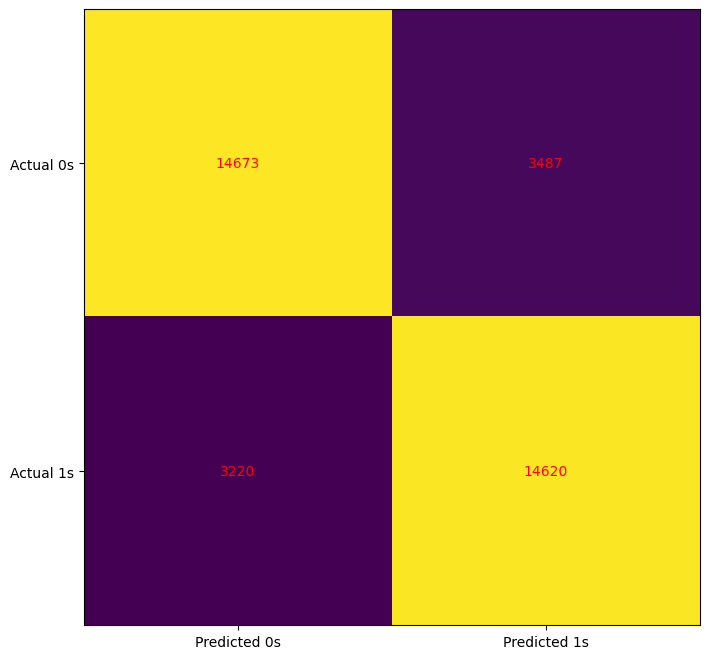

In [208]:
confusion_matrix_plot(y_test, y_predict)

In [209]:
y_test_list = y_test.tolist()
y_predict_list = y_predict.tolist()
test_list = test['Reviews'].tolist()
rating_list = test['Ratings'].tolist()

In [210]:
from colorama import Fore, Back, Style
fn_dict = {}
fp_dict = {}
for i in range(0, len(y_test_list)):
    if((y_test_list[i]=='0') & (y_predict_list[i]=='1')):
        fp_dict[i]=[test_list[i], rating_list[i]]
    elif((y_test_list[i]=='1') & (y_predict_list[i]=='0')):
        fn_dict[i] = [test_list[i], rating_list[i]]
    else:
        pass
    i+=1
for k,v in fp_dict.items():
    if v[1]<=2:
        print(Fore.RED +'False Positive: %s %s'%(k,v))
for k,v in fn_dict.items():
    if v[1]>=9:
        print(Fore.GREEN + 'False Negative: %s %s'%(k,v))

False Positive: 7 ['inside way earth developers thought consumer find appealing shape horrendous train wreck nothing redeeming developers thrust avgn great job spoofing', 1.0]
False Positive: 15 ['good satire subtle also helps immensely good satire choose watch open mind retrospect touch opening shiftless bum blow devil angel via soul well birther subtlety brick ok pj hour half later watched whole thing instantly regretted found not not laugh spent time dumbfounded inept interspersed numerous staged aman conservative rendered ammo idiots say conservatives not funny site example example prove point forced say ishucks got walk', 2.0]
False Positive: 48 ['remember liking kind films late night time moved find hard watch poorly directed poorly dubbed movies plays mad dunn evil dwarf lugosi relation neanderthal add monster named nude women sexploitation typical shlock italian old dark lot eliminate need actual production crew multiple camera set really bad dubbing shadows bad mix makes smell

### References

In [ ]:
Dataset: https://www.kaggle.com/datasets/crisbam/imdb-dataset-of-65k-movie-reviews-and-translation
https://en.wikipedia.org/wiki/Letter_frequency
https://www.geeksforgeeks.org/hyperparameters-of-random-forest-classifier/
https://www.linkedin.com/pulse/count-vectorizers-vs-tfidf-natural-language-processing-sheel-saket/
https://english.stackexchange.com/questions/353128/are-there-any-words-in-the-english-language-that-have-three-of-the-same-letters#:~:text=Sure%2C%20see%C3%ABr%20for%20one.,help%20in%20getting%20good%20answers.&text=If%20there%20were%20any%20justice,consecutive%20o%20preceding%20the%20l.
https://www.mygreatlearning.com/blog/gridsearchcv/